# Overview
The **objective** of this notebook is to visualize the data assimilation results generated from [the DART_PFLOTRAN_Integrate notebook](./DART_PFLOTRAN_Integrate.ipynb):
1. [x] [Configuration](#parameter): define directories, file locations, and other parameters
- [x] [Visualize spatial average](#plot_spatial_average): plot the time evolution of spatial-averaged prior and posterior results
- [x] [Visualize time evolution along one axis](#plot_along_zaxis):

<a id='parameter'></a>
# Configuration

In [1]:
import os
import sys
import h5py
import pickle
import f90nml
import subprocess
import numpy as np
import pandas as pd
from math import floor
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import gridspec
# plt.rcParams['figure.constrained_layout.use'] = True
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

****************
**Define the locations of application folder, DART-PFLOTRAN interface folder, and the configuation file of interest**

In [2]:
# Main directory names
app_par_dir  = "/Users/jian449/Codes/DART/manhattan/models/pflotran/applications"
dart_dir     = "/Users/jian449/Codes/DART/manhattan"
dart_pf_dir  = "/Users/jian449/Codes/DART/manhattan/models/pflotran"     # The dart pflotran utitlity folder name
fig_dir      = "/Users/jian449/OneDrive - PNNL/Documents/Publications/2020DART_PFLOTRAN/simulation_plots"

# Results folder/file of the improved DART
app_dir_improved_name = "1dthermal_test_1month_obserror005_abs_3600s_1mda"
app_dir_improved      = os.path.join(app_par_dir, app_dir_improved_name)
config_file_improved  = os.path.join(app_dir_improved, "work/config.nml")

# Results folder/file of the original DART
app_dir_original_name = "1dthermal_original_1month_obserror005_abs_3600s_1mda"
app_dir_original      = os.path.join(app_par_dir, app_dir_original_name)
config_file_original  = os.path.join(app_dir_original, "work/config.nml")

# Restuls folder/file from Kewei
app_dir_kewei_name = "kewei_results_obserror005_abs_3600s_1mda"
app_dir_kewei = os.path.join(app_par_dir, "kewei_results")


****************
**Change the locations of the all the files saved in the original config_file according to the new defined locations if necessary (this is used for the case that the application folder is moved/copied from another location)**

In [3]:
change_path_name_files = os.path.join(dart_pf_dir, "utils/change_file_paths_in_confignml.py")
subprocess.run("python {} {} {} {}".format(change_path_name_files, config_file_improved, 
                                           dart_pf_dir, app_dir_improved),
               shell=True, check=True)
subprocess.run("python {} {} {} {}".format(change_path_name_files, config_file_original, 
                                           dart_pf_dir, app_dir_original),
               shell=True, check=True)


CompletedProcess(args='python /Users/jian449/Codes/DART/manhattan/models/pflotran/utils/change_file_paths_in_confignml.py /Users/jian449/Codes/DART/manhattan/models/pflotran/applications/1dthermal_original_1month_obserror005_abs_3600s_1mda/work/config.nml /Users/jian449/Codes/DART/manhattan/models/pflotran /Users/jian449/Codes/DART/manhattan/models/pflotran/applications/1dthermal_original_1month_obserror005_abs_3600s_1mda', returncode=0)

****************
**Import the visualization functions**

In [4]:
sys.path.append(dart_pf_dir)
from utils.plot_da_result import DaResults, plot_compare_multiple_daresults

# Some functions

In [66]:
def get_temperature_posterior_fromh5(pflotran_out, posterior_temp_from_h, nens=None):
    if os.path.exists(posterior_temp_from_h):
        data = np.load(posterior_temp_from_h, allow_pickle=True)
        posterior, time_vset_day_sorted = data.item()['value'], data.item()['time']
    else:
        for i in range(nens):
            file_name = os.path.join(pflotran_out, "pflotranR{}.h5".format(i+1))

            var_name = 'Temperature [C]'

            f_out = h5py.File(file_name, 'r')

            # Get all the time steps
            time_set_o = np.array([t for t in list(f_out.keys()) if t.startswith("Time")])
            time_set   = np.array([t.split()[1:] for t in time_set_o])
            time_vset  = np.array([float(t[0]) for t in time_set])
            time_unit  = time_set[0][1]

            # Shift the time_vset by the model spinup time
            # time_vset = time_vset - spinup_time * 86400

            if time_unit in ["s", "sec", "second"]: # Convert from seconds to fractional days
                time_vset_day  = time_vset / 86400. 

            # Sort the time indices
            indices = np.argsort(time_vset)
            time_vset_sorted = time_vset[indices]
            time_vset_day_sorted = time_vset_day[indices]
            time_set_o_sorted = time_set_o[indices]

            if i == 0:
                posterior = np.zeros([65, len(time_set), nens])

            # Get the state/parameter/variable values required in pflotran_var_set
            for j in range(len(time_vset)):
                time_o           = time_set_o_sorted[j]
                dataset          = f_out[time_o]
                pl_out_var_set_o = list(dataset.keys())
                posterior[:,j,i] = dataset[var_name][:]
        np.save(posterior_temp_from_h, {"value":posterior,"time":time_vset_day_sorted})
    
    return posterior, time_vset_day_sorted

def plot_temperature(dar, posterior, time_set, gs):
    # Get the parameter
    obs_set               = dar.obs_set
    pflotran_var_set      = dar.pflotran_var_set
    model_time_list       = dar.model_time_list
    model_time_dates_list = dar.model_time_dates_list
    obs_time_set_used     = dar.obs_time_set_used
    obs_value_set_used    = dar.obs_value_set_used
    obs_loc_set           = dar.obs_loc_set
    spinup_dt_num = int(3600*2/300)

    ntime = len(obs_time_set_used)

    model_time_list2 = np.arange(model_time_list[0], model_time_list[-1], 300./86400)
    
    posterior_time_set  = time_set[(time_set>=model_time_list[0])&(time_set<=model_time_list[-1])]
    posterior = posterior[:,(time_set>=model_time_list[0])&(time_set<=model_time_list[-1]),:]
    
#     posterior_set = [posterior[-5,1:ntime+1,:],posterior[-15,1:ntime+1,:],posterior[-25,1:ntime+1,:]]
    posterior_set = [posterior[-5,:,:],posterior[-15,:,:],posterior[-25,:,:]]

    xloc_set, yloc_set, zloc_set = dar.x_loc, dar.y_loc, dar.z_loc

    # Get the locations associated with this observation variable
    _, nloc = obs_loc_set.shape
    _, _, nens = posterior.shape
    # nvar_obs = len(obs_set)

    # Define axes array
    axes = np.empty(nloc, dtype=object)

    ##############################
    # Plot the temporal evolution of the ensemble, the mean, and the observation
    # at each observed location
    for i in range(nloc):
        posterior_current = posterior_set[i]
        ax = plt.subplot(gs[i])
        for j in range(nens):
            posterior_ens = posterior_current[:, j]
            line1, = ax.plot(posterior_time_set, posterior_ens, color='grey', linewidth=0.5, linestyle=':', label='ensemble')
        posterior_mean = np.mean(posterior_current, axis=(1))

        # Plot the posterior
        line2, = ax.plot(posterior_time_set, posterior_mean, color='red', linewidth=1, label='mean')
        obs_used = obs_value_set_used['TEMPERATURE'][i, :]
        line3, = ax.plot(obs_time_set_used, obs_used, color='black', linewidth=1, label='obs')
        ax.set_ylim([4, 10])

        axes[i] = ax
    
    return axes, line1, line2, line3

def plot_temperature_diff(dar, posterior, time_set, gs):
    # Get the parameter
    obs_set               = dar.obs_set
    pflotran_var_set      = dar.pflotran_var_set
    model_time_list       = dar.model_time_list
    model_time_dates_list = dar.model_time_dates_list
    obs_time_set_used     = dar.obs_time_set_used
    obs_value_set_used    = dar.obs_value_set_used
    obs_loc_set           = dar.obs_loc_set

    ntime = len(obs_time_set_used)
    
    _, _, nens = posterior.shape
    
    posterior_time_set  = time_set[(time_set>=obs_time_set_used[0])&(time_set<=obs_time_set_used[-1])]
    posterior = posterior[:,(time_set>=obs_time_set_used[0])&(time_set<=obs_time_set_used[-1]),:]
    
#     posterior_set = [posterior[-5,1:ntime+1,:],posterior[-15,1:ntime+1,:],posterior[-25,1:ntime+1,:]]
    posterior_set = [posterior[-5,:,:],posterior[-15,:,:],posterior[-25,:,:]]

    # Define axes array
    axes = np.empty(nloc, dtype=object)

    ##############################
    # Plot the temporal evolution of the ensemble, the mean, and the observation
    # at each observed location
    diff_mean_set = []
    for i in range(nloc):
        posterior_current = posterior_set[i]
        obs_used = obs_value_set_used['TEMPERATURE'][i, :]

        # Plot the error
        ax2 = plt.subplot(gs[i])
        diff = np.zeros([ntime, nens])
        for j in range(nens):
            diff[:, j] = posterior_current[:,j] - obs_used
        diff_mean = np.mean(diff, axis=1)
        diff_mean_abs = np.abs(diff_mean)
        diff_std  = np.std(diff, axis=1)
        line1,=ax2.plot(obs_time_set_used, diff_mean, color='blue', linewidth=1, label='mean')
        ax2.axhline(y=0,color='k',linestyle='--',linewidth=0.5)
        ax2.tick_params(axis='y', labelcolor='blue')
        ax2.set_ylim([-.6,.6])
        
        diff_mean_set.append(diff_mean)

        # Plot the bias
        ax22 = ax2.twinx()  # instantiate a second axes that shares the same x-axis
    #     ax22.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
        ax22.tick_params(axis='y', labelcolor='red')
        ax22.set_ylim([-.6,.6])
        line2,=ax22.plot(obs_time_set_used, diff_mean_abs, alpha=1., linestyle='--', color='red', linewidth=1, label='mean')
    #     line3,=ax2.plot(obs_time_set_used, diff_std, '*-', color='black', linewidth=1, label='mean')

        axes[i] = ax2
    return axes, line1, line2, diff_mean_set

def plot_temperature_mse(dar, posterior, time_set, gs):
    # Get the parameter
    obs_set               = dar.obs_set
    pflotran_var_set      = dar.pflotran_var_set
    model_time_list       = dar.model_time_list
    model_time_dates_list = dar.model_time_dates_list
    obs_time_set_used     = dar.obs_time_set_used
    obs_value_set_used    = dar.obs_value_set_used
    obs_loc_set           = dar.obs_loc_set

    ntime = len(obs_time_set_used)
    
    _, _, nens = posterior.shape
    
    posterior_time_set  = time_set[(time_set>=obs_time_set_used[0])&(time_set<=obs_time_set_used[-1])]
    posterior = posterior[:,(time_set>=obs_time_set_used[0])&(time_set<=obs_time_set_used[-1]),:]
    
#     posterior_set = [posterior[-5,1:ntime+1,:],posterior[-15,1:ntime+1,:],posterior[-25,1:ntime+1,:]]
    posterior_set = [posterior[-5,:,:],posterior[-15,:,:],posterior[-25,:,:]]

    # Define axes array
    axes = np.empty(nloc, dtype=object)

    ##############################
    # Plot the temporal evolution of the variance, bias, and mean squared error
    # at each observed location
    var_set, bias_set, mse_set = [], [], []
    for i in range(nloc):
        posterior_current = posterior_set[i]
        obs_used = obs_value_set_used['TEMPERATURE'][i, :]

        # Plot the variance
        ax = plt.subplot(gs[i])
        variance = np.var(posterior_current, axis=1)
        line1=ax.fill_between(obs_time_set_used, 0, variance, alpha=.5, color='blue', label='VAR')
        ax.axhline(y=0,color='k',linestyle='--',linewidth=0.5)
#         ax2.set_ylim([-.6,.6])

        # Plot the squared bias
        diff = np.zeros([ntime, nens])
        for j in range(nens):
            diff[:, j] = posterior_current[:,j] - obs_used
        diff_mean = np.mean(diff, axis=1)
        bias = np.square(diff_mean)
        line2=ax.fill_between(obs_time_set_used, variance, variance+bias, alpha=.5, color='red', label='bias^2')
        
        # Plot the MSE
        mse = bias+variance
        line3,=ax.plot(obs_time_set_used, variance+bias, color='black', linewidth=.5, label='MSE')
#         diff_mean_set.append(diff_mean)
    
        axes[i] = ax
        var_set.append(variance); bias_set.append(bias); mse_set.append(mse)
    return axes, line1, line2, line3, var_set, bias_set, mse_set

def plot_flux_diff(dar, true_file_name, axes, ylim=None):
    var_name='FLOW_FLUX'
    # Get the parameter
    nens , ntime     = dar.nens,  dar.ntime
    prior, posterior = dar.prior, dar.posterior

    assim_start_str       = dar.assim_start_time
    pflotran_var_set      = dar.pflotran_var_set
    model_time_list       = dar.model_time_list
    model_time_dates_list = dar.model_time_dates_list
    model_start_time      = dar.model_start_time
    model_end_time        = dar.model_end_time
    tunits                = dar.tunits

    # Get the reference, start and end dates
    ref_time = datetime.strptime(assim_start_str, "%Y-%m-%d %H:%M:%S")
    # model_start_date, model_end_date = model_time_dates_list[0], model_time_dates_list[-1]

    # Read the true value from file_name
    true_set           = pd.read_csv(true_file_name)
    true_set_raw_time  = true_set.iloc[:, 0].values
    true_set_dates     = [datetime.strptime(t, '%m/%d/%Y %H:%M') for t in true_set_raw_time]
    dates_ref          = [t-ref_time for t in true_set_dates]
    true_set_time      = np.array([t.days+float(t.seconds)/86400. for t in dates_ref])
    true               = true_set.iloc[:, 1].values
    true_set_used_ind  = (true_set_time >= model_start_time) & (true_set_time <= model_end_time)
    true_set_time_used = true_set_time[true_set_used_ind]
    true_set_used      = true[true_set_used_ind]
    
    model_time_offset = 1800./86400.
    true_set_used_ave = [np.mean(true[(true_set_time >  (model_time_list[i-1]+model_time_offset)) & 
                                      (true_set_time <= (model_time_list[i]+model_time_offset))]) 
    #                      if i != 0 else np.mean(true[(true_set_time >  (model_time_list[i]-model_time_offset)) & 
    #                                                  (true_set_time <= (model_time_list[i]+model_time_offset))])
                         if i != 0 else np.mean(true[true_set_time <= (model_time_list[i]+model_time_offset)])
                         for i in range(len(model_time_list))]

    # Get the spatially averaged analyzed variable (prior and posterior)
    var_ind                = pflotran_var_set.index(var_name)
    analyzed_prior_ens     = np.mean(prior[var_ind, :, :, :, :, :], axis=(2, 3, 4))
    analyzed_posterior_ens = np.mean(posterior[var_ind, :, :, :, :, :], axis=(2, 3, 4))

    diff_mean_set = []
    # Plot the prior
    ax1 = axes[0]
    # Plot the error
    diff = np.zeros([ntime, nens])
    for j in range(nens):
        diff[:, j] = analyzed_prior_ens[j,:] - true_set_used_ave
    diff_mean = np.mean(diff, axis=1)
    diff_mean_abs = np.abs(diff_mean)
    diff_std  = np.std(diff, axis=1)
    line1,=ax1.plot(model_time_list, diff_mean, color='blue', linewidth=1, label='mean')
    ax1.axhline(y=0,color='k',linestyle='--',linewidth=0.5)
    ax1.tick_params(axis='y', labelcolor='blue')
    # Plot the bias
    ax12 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax12.tick_params(axis='y', labelcolor='red')
    line2,=ax12.plot(model_time_list, diff_mean_abs, alpha=1., linestyle='--', color='red', linewidth=1, label='mean') 
    diff_mean_set.append(diff_mean)
    
    # Plot the posterior
    ax2 = axes[1]
    # Plot the error
    diff = np.zeros([ntime, nens])
    for j in range(nens):
        diff[:, j] = analyzed_posterior_ens[j,:] - true_set_used_ave
    diff_mean = np.mean(diff, axis=1)
    diff_mean_abs = np.abs(diff_mean)
    diff_std  = np.std(diff, axis=1)
    line1,=ax2.plot(model_time_list, diff_mean, color='blue', linewidth=1, label='mean')
    ax2.axhline(y=0,color='k',linestyle='--',linewidth=0.5)
    ax2.tick_params(axis='y', labelcolor='blue')
    # Plot the bias
    ax22 = ax2.twinx()  # instantiate a second axes that shares the same x-axis
    ax22.tick_params(axis='y', labelcolor='red')
    line2,=ax22.plot(model_time_list, diff_mean_abs, alpha=1., linestyle='--', color='red', linewidth=1, label='mean')    
    diff_mean_set.append(diff_mean)
    
    # Plot the labels and titles
    # ax1.set_title("Prior ({})".format(var_name))
    # ax2.set_title("Posterior ({})".format(var_name))
    ax2.set_xlabel("Time (day)")
    ax2.set_ylim(ylim)
    ax12.set_ylim(ylim)
    ax22.set_ylim(ylim)
    
    return axes, line1, line2, diff_mean_set

def plot_flux_mse(dar, true_file_name, axes, ylim=None):
    var_name='FLOW_FLUX'
    # Get the parameter
    nens , ntime     = dar.nens,  dar.ntime
    prior, posterior = dar.prior, dar.posterior

    assim_start_str       = dar.assim_start_time
    pflotran_var_set      = dar.pflotran_var_set
    model_time_list       = dar.model_time_list
    model_time_dates_list = dar.model_time_dates_list
    model_start_time      = dar.model_start_time
    model_end_time        = dar.model_end_time
    tunits                = dar.tunits

    # Get the reference, start and end dates
    ref_time = datetime.strptime(assim_start_str, "%Y-%m-%d %H:%M:%S")
    # model_start_date, model_end_date = model_time_dates_list[0], model_time_dates_list[-1]

    # Read the true value from file_name
    true_set           = pd.read_csv(true_file_name)
    true_set_raw_time  = true_set.iloc[:, 0].values
    true_set_dates     = [datetime.strptime(t, '%m/%d/%Y %H:%M') for t in true_set_raw_time]
    dates_ref          = [t-ref_time for t in true_set_dates]
    true_set_time      = np.array([t.days+float(t.seconds)/86400. for t in dates_ref])
    true               = true_set.iloc[:, 1].values
    true_set_used_ind  = (true_set_time >= model_start_time) & (true_set_time <= model_end_time)
    true_set_time_used = true_set_time[true_set_used_ind]
    true_set_used      = true[true_set_used_ind]
    
    model_time_offset = 1800./86400.
    true_set_used_ave = [np.mean(true[(true_set_time >  (model_time_list[i-1]+model_time_offset)) & 
                                      (true_set_time <= (model_time_list[i]+model_time_offset))]) 
    #                      if i != 0 else np.mean(true[(true_set_time >  (model_time_list[i]-model_time_offset)) & 
    #                                                  (true_set_time <= (model_time_list[i]+model_time_offset))])
                         if i != 0 else np.mean(true[true_set_time <= (model_time_list[i]+model_time_offset)])
                         for i in range(len(model_time_list))]

    # Get the spatially averaged analyzed variable (prior and posterior)
    var_ind                = pflotran_var_set.index(var_name)
    analyzed_prior_ens     = np.mean(prior[var_ind, :, :, :, :, :], axis=(2, 3, 4))
    analyzed_posterior_ens = np.mean(posterior[var_ind, :, :, :, :, :], axis=(2, 3, 4))

    var_set,bias_set, mse_set = [], [], []
    # Plot the prior
    ax1 = axes[0]
    # Plot the variance
    variance = np.var(analyzed_prior_ens, axis=0)
    line1=ax1.fill_between(model_time_list, 0, variance, color='blue', alpha=0.5, label='VAR')
    ax1.axhline(y=0,color='k',linestyle='--',linewidth=0.5)
    # Plot the squared bias
    diff = np.zeros([ntime, nens])
    for j in range(nens):
        diff[:, j] = analyzed_prior_ens[j,:] - true_set_used_ave
    diff_mean = np.mean(diff, axis=1)
    bias = np.square(diff_mean)
    line2=ax1.fill_between(model_time_list, variance, variance+bias, alpha=.5, color='red', label='BIAS') 
    # Plot the mse
    mse = bias + variance
    line3,=ax1.plot(model_time_list, mse, color='black', linewidth=.5, label='MSE')
    var_set.append(variance); bias_set.append(bias); mse_set.append(mse)
    
    # Plot the posterior
    ax2 = axes[1]
    # Plot the variance
    variance = np.var(analyzed_posterior_ens, axis=0)
    line1=ax2.fill_between(model_time_list, 0, variance, color='blue', alpha=0.5, label='VAR')
    ax2.axhline(y=0,color='k',linestyle='--',linewidth=0.5)
    # Plot the bias
    diff = np.zeros([ntime, nens])
    for j in range(nens):
        diff[:, j] = analyzed_posterior_ens[j,:] - true_set_used_ave
    diff_mean = np.mean(diff, axis=1)
    bias = np.square(diff_mean)
    line2=ax2.fill_between(model_time_list, variance, variance+bias, alpha=.5, color='red', label='BIAS')    
    # Plot the mse
    mse = bias + variance
    line3,=ax2.plot(model_time_list,mse, color='black', linewidth=.5, label='MSE')
    var_set.append(variance); bias_set.append(bias); mse_set.append(mse)
    
    # Plot the labels and titles
    # ax1.set_title("Prior ({})".format(var_name))
    # ax2.set_title("Posterior ({})".format(var_name))
    ax2.set_xlabel("Time (day)")
    ax2.set_ylim(ylim)
    
    return axes, line1, line2, line3, var_set, bias_set, mse_set


In [114]:
def plot_temperature_bias(dar, posterior, time_set, gs):
    # Get the parameter
    obs_set               = dar.obs_set
    pflotran_var_set      = dar.pflotran_var_set
    model_time_list       = dar.model_time_list
    model_time_dates_list = dar.model_time_dates_list
    obs_time_set_used     = dar.obs_time_set_used
    obs_value_set_used    = dar.obs_value_set_used
    obs_loc_set           = dar.obs_loc_set

    ntime = len(obs_time_set_used)
    
    _, _, nens = posterior.shape
    
    posterior_time_set  = time_set[(time_set>=obs_time_set_used[0])&(time_set<=obs_time_set_used[-1])]
    posterior = posterior[:,(time_set>=obs_time_set_used[0])&(time_set<=obs_time_set_used[-1]),:]
    
#     posterior_set = [posterior[-5,1:ntime+1,:],posterior[-15,1:ntime+1,:],posterior[-25,1:ntime+1,:]]
    posterior_set = [posterior[-5,:,:],posterior[-15,:,:],posterior[-25,:,:]]

    # Define axes array
    axes = np.empty(nloc, dtype=object)

    ##############################
    # Plot the temporal evolution of the variance, bias, and mean squared error
    # at each observed location
    var_set, bias_set, mse_set = [], [], []
    for i in range(nloc):
        posterior_current = posterior_set[i]
        obs_used = obs_value_set_used['TEMPERATURE'][i, :]

        # Plot the squared bias
        ax = plt.subplot(gs[i])
        diff = np.zeros([ntime, nens])
        for j in range(nens):
            diff[:, j] = posterior_current[:,j] - obs_used
        diff_mean = np.mean(diff, axis=1)
        bias = np.abs(diff_mean)
        line,=ax.plot(obs_time_set_used, bias, linewidth=1, color='blue', label='bias^2')
        ax.axhline(y=0,color='k',linestyle='--',linewidth=0.5)
    
        axes[i] = ax
        bias_set.append(bias)
    return axes, line, bias_set

def plot_temperature_variance(dar, posterior, time_set, gs):
    # Get the parameter
    obs_set               = dar.obs_set
    pflotran_var_set      = dar.pflotran_var_set
    model_time_list       = dar.model_time_list
    model_time_dates_list = dar.model_time_dates_list
    obs_time_set_used     = dar.obs_time_set_used
    obs_value_set_used    = dar.obs_value_set_used
    obs_loc_set           = dar.obs_loc_set

    ntime = len(obs_time_set_used)
    
    _, _, nens = posterior.shape
    
    posterior_time_set  = time_set[(time_set>=obs_time_set_used[0])&(time_set<=obs_time_set_used[-1])]
    posterior = posterior[:,(time_set>=obs_time_set_used[0])&(time_set<=obs_time_set_used[-1]),:]
    
#     posterior_set = [posterior[-5,1:ntime+1,:],posterior[-15,1:ntime+1,:],posterior[-25,1:ntime+1,:]]
    posterior_set = [posterior[-5,:,:],posterior[-15,:,:],posterior[-25,:,:]]

    # Define axes array
    axes = np.empty(nloc, dtype=object)

    ##############################
    # Plot the temporal evolution of the variance, bias, and mean squared error
    # at each observed location
    var_set = []
    for i in range(nloc):
        posterior_current = posterior_set[i]
        obs_used = obs_value_set_used['TEMPERATURE'][i, :]

        # Plot the variance
        ax = plt.subplot(gs[i])
        variance = np.var(posterior_current, axis=1)
        line,=ax.plot(obs_time_set_used, variance, linewidth=1, color='red', label='VAR')
        ax.axhline(y=0,color='k',linestyle='--',linewidth=0.5)
    
        axes[i] = ax
        var_set.append(variance)
    return axes, line, var_set

def plot_flux_bias(dar, true_file_name, axes, ylim=None):
    var_name='FLOW_FLUX'
    # Get the parameter
    nens , ntime     = dar.nens,  dar.ntime
    prior, posterior = dar.prior, dar.posterior

    assim_start_str       = dar.assim_start_time
    pflotran_var_set      = dar.pflotran_var_set
    model_time_list       = dar.model_time_list
    model_time_dates_list = dar.model_time_dates_list
    model_start_time      = dar.model_start_time
    model_end_time        = dar.model_end_time
    tunits                = dar.tunits

    # Get the reference, start and end dates
    ref_time = datetime.strptime(assim_start_str, "%Y-%m-%d %H:%M:%S")
    # model_start_date, model_end_date = model_time_dates_list[0], model_time_dates_list[-1]

    # Read the true value from file_name
    true_set           = pd.read_csv(true_file_name)
    true_set_raw_time  = true_set.iloc[:, 0].values
    true_set_dates     = [datetime.strptime(t, '%m/%d/%Y %H:%M') for t in true_set_raw_time]
    dates_ref          = [t-ref_time for t in true_set_dates]
    true_set_time      = np.array([t.days+float(t.seconds)/86400. for t in dates_ref])
    true               = true_set.iloc[:, 1].values
    true_set_used_ind  = (true_set_time >= model_start_time) & (true_set_time <= model_end_time)
    true_set_time_used = true_set_time[true_set_used_ind]
    true_set_used      = true[true_set_used_ind]
    
    model_time_offset = 1800./86400.
    true_set_used_ave = [np.mean(true[(true_set_time >  (model_time_list[i-1]+model_time_offset)) & 
                                      (true_set_time <= (model_time_list[i]+model_time_offset))]) 
    #                      if i != 0 else np.mean(true[(true_set_time >  (model_time_list[i]-model_time_offset)) & 
    #                                                  (true_set_time <= (model_time_list[i]+model_time_offset))])
                         if i != 0 else np.mean(true[true_set_time <= (model_time_list[i]+model_time_offset)])
                         for i in range(len(model_time_list))]

    # Get the spatially averaged analyzed variable (prior and posterior)
    var_ind                = pflotran_var_set.index(var_name)
    analyzed_prior_ens     = np.mean(prior[var_ind, :, :, :, :, :], axis=(2, 3, 4))
    analyzed_posterior_ens = np.mean(posterior[var_ind, :, :, :, :, :], axis=(2, 3, 4))

    var_set,bias_set, mse_set = [], [], []
    # Plot the prior
    ax1 = axes[0]
    # Plot the squared bias
    diff = np.zeros([ntime, nens])
    for j in range(nens):
        diff[:, j] = analyzed_prior_ens[j,:] - true_set_used_ave
    diff_mean = np.mean(diff, axis=1)
    bias = np.square(diff_mean)
    line,=ax1.plot(model_time_list, bias, linewidth=1., color='blue', label='BIAS') 
    bias_set.append(bias)
    
    # Plot the posterior
    ax2 = axes[1]
    # Plot the bias
    diff = np.zeros([ntime, nens])
    for j in range(nens):
        diff[:, j] = analyzed_posterior_ens[j,:] - true_set_used_ave
    diff_mean = np.mean(diff, axis=1)
    bias = np.square(diff_mean)
    line,=ax2.plot(model_time_list, bias, linewidth=1., color='blue', label='BIAS')    
    bias_set.append(bias)
    
    # Plot the labels and titles
    # ax1.set_title("Prior ({})".format(var_name))
    # ax2.set_title("Posterior ({})".format(var_name))
    ax2.set_xlabel("Time (day)")
    ax2.set_ylim(ylim)
    
    return axes, line, bias_set

def plot_flux_variance(dar, true_file_name, axes, ylim=None):
    var_name='FLOW_FLUX'
    # Get the parameter
    nens , ntime     = dar.nens,  dar.ntime
    prior, posterior = dar.prior, dar.posterior

    assim_start_str       = dar.assim_start_time
    pflotran_var_set      = dar.pflotran_var_set
    model_time_list       = dar.model_time_list
    model_time_dates_list = dar.model_time_dates_list
    model_start_time      = dar.model_start_time
    model_end_time        = dar.model_end_time
    tunits                = dar.tunits

    # Get the reference, start and end dates
    ref_time = datetime.strptime(assim_start_str, "%Y-%m-%d %H:%M:%S")
    # model_start_date, model_end_date = model_time_dates_list[0], model_time_dates_list[-1]

    # Read the true value from file_name
    true_set           = pd.read_csv(true_file_name)
    true_set_raw_time  = true_set.iloc[:, 0].values
    true_set_dates     = [datetime.strptime(t, '%m/%d/%Y %H:%M') for t in true_set_raw_time]
    dates_ref          = [t-ref_time for t in true_set_dates]
    true_set_time      = np.array([t.days+float(t.seconds)/86400. for t in dates_ref])
    true               = true_set.iloc[:, 1].values
    true_set_used_ind  = (true_set_time >= model_start_time) & (true_set_time <= model_end_time)
    true_set_time_used = true_set_time[true_set_used_ind]
    true_set_used      = true[true_set_used_ind]
    
    model_time_offset = 1800./86400.
    true_set_used_ave = [np.mean(true[(true_set_time >  (model_time_list[i-1]+model_time_offset)) & 
                                      (true_set_time <= (model_time_list[i]+model_time_offset))]) 
    #                      if i != 0 else np.mean(true[(true_set_time >  (model_time_list[i]-model_time_offset)) & 
    #                                                  (true_set_time <= (model_time_list[i]+model_time_offset))])
                         if i != 0 else np.mean(true[true_set_time <= (model_time_list[i]+model_time_offset)])
                         for i in range(len(model_time_list))]

    # Get the spatially averaged analyzed variable (prior and posterior)
    var_ind                = pflotran_var_set.index(var_name)
    analyzed_prior_ens     = np.mean(prior[var_ind, :, :, :, :, :], axis=(2, 3, 4))
    analyzed_posterior_ens = np.mean(posterior[var_ind, :, :, :, :, :], axis=(2, 3, 4))

    var_set = []
    # Plot the prior
    ax1 = axes[0]
    # Plot the variance
    variance = np.var(analyzed_prior_ens, axis=0)
    line,=ax1.plot(model_time_list, variance, color='blue', linewidth=1., label='VAR')
    ax1.axhline(y=0,color='k',linestyle='--',linewidth=0.5)
    var_set.append(variance)
    
    # Plot the posterior
    ax2 = axes[1]
    # Plot the variance
    variance = np.var(analyzed_posterior_ens, axis=0)
    line1,=ax2.plot(model_time_list, variance, color='blue', linewidth=1., label='VAR')
    ax2.axhline(y=0,color='k',linestyle='--',linewidth=0.5)
    var_set.append(variance)
    
    # Plot the labels and titles
    # ax1.set_title("Prior ({})".format(var_name))
    # ax2.set_title("Posterior ({})".format(var_name))
    ax2.set_xlabel("Time (day)")
    ax2.set_ylim(ylim)
    
    return axes, line, var_set


# Results from the improved DART

In [6]:
dar1 = DaResults(config_file_improved)
dar1.obs_nc = os.path.join(app_dir_improved, "pflotran_input/obs_true_pflotran_clipped.nc") # Put the true data instead of observation data
dar1.setup(from_concatenated=0)
nvar = dar1.nvar

<a id='plot_spatial_average'></a>
## Visualize spatial average results

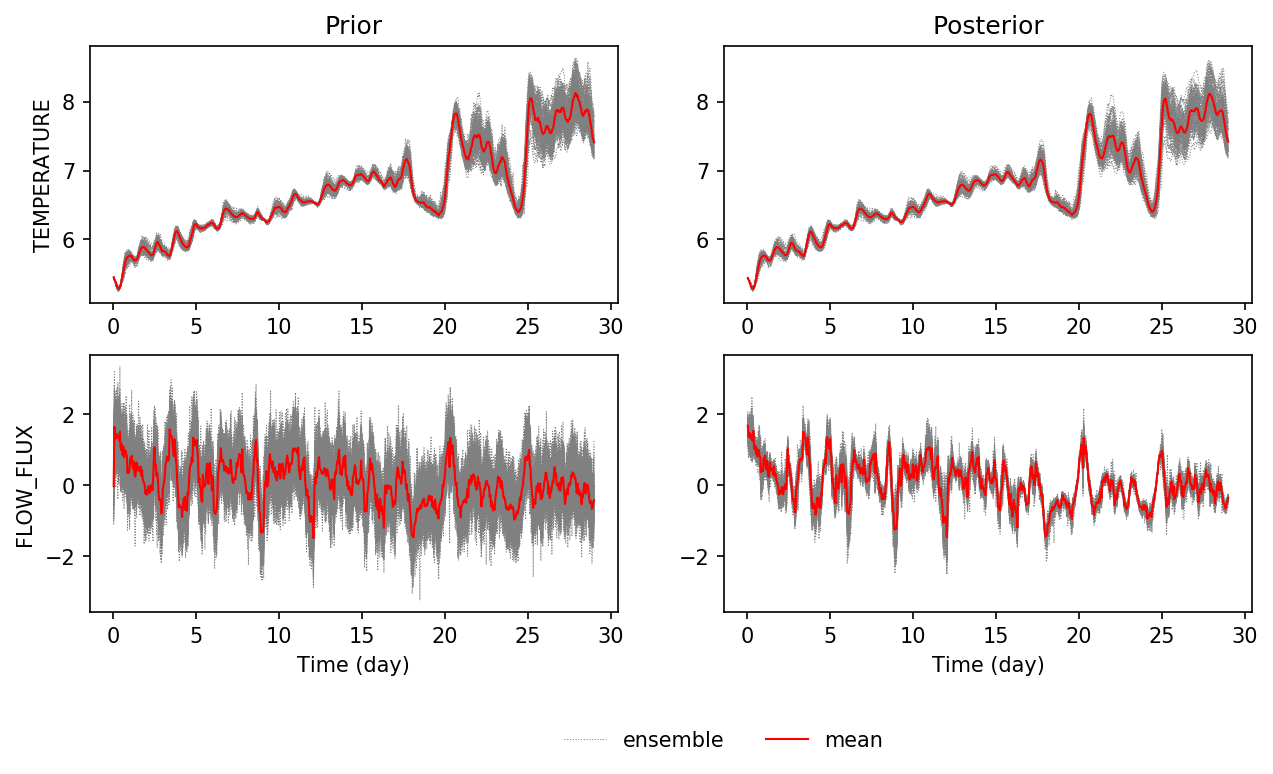

In [7]:
fig = plt.figure(num=1,dpi=150, figsize=(10,5), constrained_layout=True)
gs = gridspec.GridSpec(nvar, 2, width_ratios=[1, 1])
axes = np.empty([nvar, 2], dtype=object)
for i in range(nvar):
    axes[i, 0] = plt.subplot(gs[i, 0])
    axes[i, 1] = plt.subplot(gs[i, 1], sharey=axes[i, 0], sharex=axes[i, 0])
dar1.plot_spatial_average(axes)
# plt.savefig(os.path.join(fig_dir, app_dir_improved_name+"_general_results.png"), dpi=150)

## Temperature (from HDF5 file)
Note that the HDF5 file contains model states in different time steps

In [36]:
# Get the posterior from the model output
pflotran_out1 = os.path.join(app_dir_improved, "pflotran_output")
posterior_temp_from_h1 = os.path.join(pflotran_out1,'posterior_temperature_fromh5.npy')

posterior1, temp_times1 = get_temperature_posterior_fromh5(pflotran_out1, posterior_temp_from_h1, dar1.nens)
temp_times1 = temp_times1 - 7200./86400. # Get rid of the spinup time

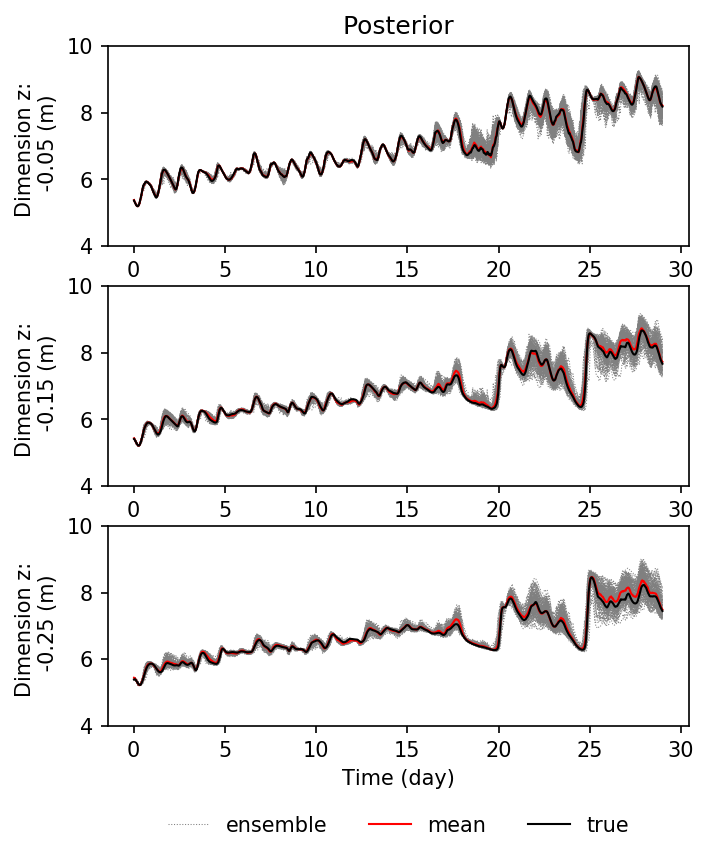

In [37]:
# Plot
obs_loc_set = dar1.obs_loc_set
_, nloc     = obs_loc_set.shape
fig = plt.figure(num=1, dpi=150, figsize=(5,6), constrained_layout=True)
gs = gridspec.GridSpec(nloc, 1, height_ratios=[1, 1, 1])        
axes, line1, line2, line3 = plot_temperature(dar1, posterior1, temp_times1, gs)
# Plot the legends
# plt.legend(frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.9, -0.3))
plt.legend((line1, line2, line3), ('ensemble', 'mean', 'true'), frameon=False, ncol=3, loc="center", bbox_to_anchor=(0.5, -0.5))

# Plot the labels and titles
axes[0].set_title("Posterior")
axes[-1].set_xlabel("Time (day)")
for i in range(nloc):
    axes[i].set_ylabel("Dimension z: \n %.2f (m)" % (obs_loc_set[2, i]))
# plt.savefig(os.path.join(fig_dir, app_dir_improved_name+"_temperature_results.png"), dpi=150)

### bias and error

Text(0.5, 0, 'Time (day)')

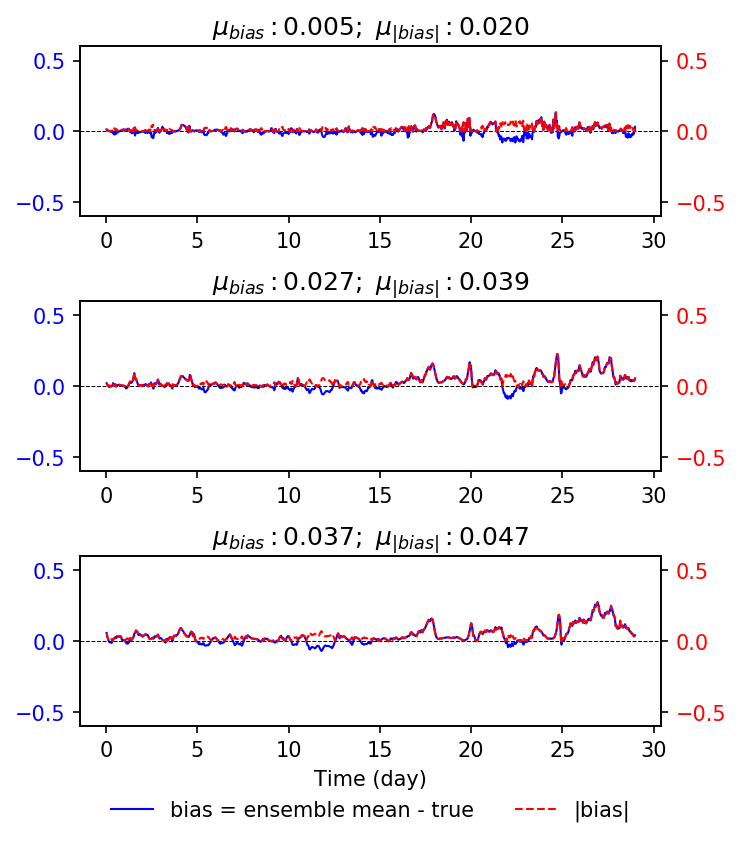

In [120]:
# Plot
obs_loc_set = dar1.obs_loc_set
_, nloc     = obs_loc_set.shape
fig = plt.figure(num=1, dpi=150, figsize=(5,6), constrained_layout=True)
gs = gridspec.GridSpec(nloc, 1, height_ratios=[1, 1, 1])        
axes, line1, line2, diff_mean_set = plot_temperature_diff(dar1, posterior1, temp_times1, gs)     

for i in range(nloc):
    diff_mean = diff_mean_set[i]
    axes[i].set_title("$\mu_{bias}: %.3f;$ $\mu_{|bias|}: %.3f$" % 
                      (np.mean(diff_mean),np.mean(np.abs(diff_mean))))

# Plot the legends
# plt.legend(frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.9, -0.3))
plt.subplots_adjust(hspace=0.5)
plt.legend((line1, line2), ('bias = ensemble mean - true', '|bias|'), 
           frameon=False, ncol=3, loc="center", bbox_to_anchor=(0.5, -0.5))

# Plot the labels and titles
# axes[0].set_title("Posterior")
axes[-1].set_xlabel("Time (day)")
# for i in range(nloc):
#     axes[i].set_ylabel("Dimension z: \n %.2f (m)" % (obs_loc_set[2, i]))
# plt.savefig(os.path.join(fig_dir, app_dir_improved_name+"_temperature_errorbias.png"), dpi=150)

### bias and variance

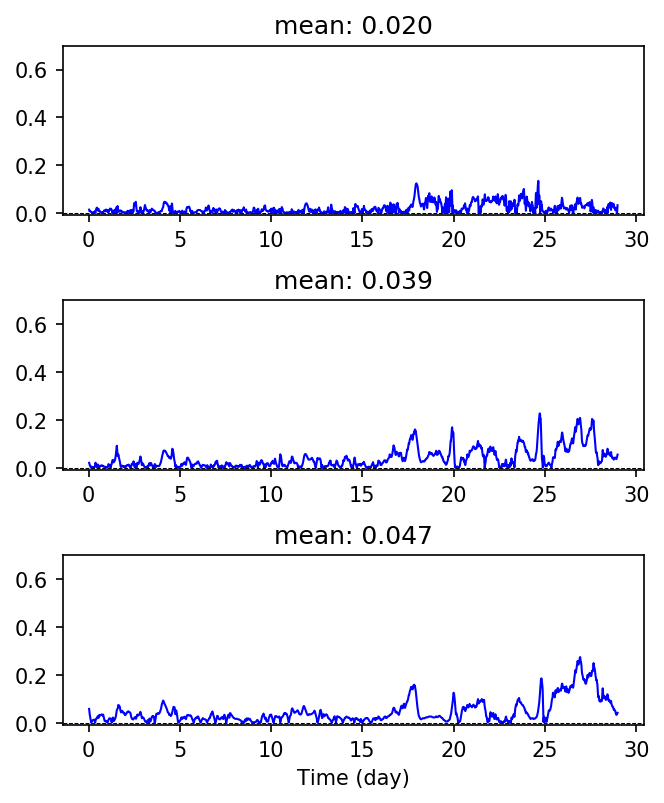

In [109]:
# Plot
obs_loc_set = dar1.obs_loc_set
_, nloc     = obs_loc_set.shape
fig = plt.figure(num=1, dpi=150, figsize=(5,6), constrained_layout=True)
gs = gridspec.GridSpec(nloc, 1, height_ratios=[1, 1, 1])        
axes, line, bias_set = plot_temperature_bias(dar1, posterior1, temp_times1, gs)     

for i in range(nloc):
    axes[i].set_title("mean: %.3f" % (np.mean(bias_set[i])))

# Plot the legends
plt.subplots_adjust(hspace=0.5)
# plt.legend((line), ('|bias| = |ensemble mean - true|'), 
#            frameon=False, ncol=3, loc="center", bbox_to_anchor=(0.5, -0.5))

# Plot the labels and titles
# axes[0].set_title("Posterior")
axes[-1].set_xlabel("Time (day)")
for i in range(nloc):
    axes[i].set_ylim([-0.01, 0.7])
# for i in range(nloc):
#     axes[i].set_ylabel("Dimension z: \n %.2f (m)" % (obs_loc_set[2, i]))
# plt.savefig(os.path.join(fig_dir, app_dir_improved_name+"_temperature_bias.png"), dpi=150)

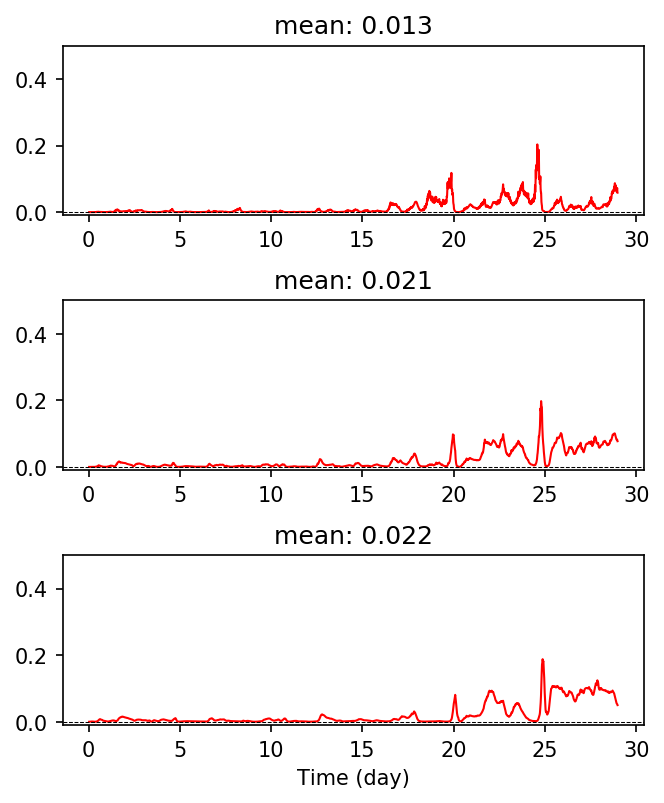

In [102]:
# Plot
obs_loc_set = dar1.obs_loc_set
_, nloc     = obs_loc_set.shape
fig = plt.figure(num=1, dpi=150, figsize=(5,6), constrained_layout=True)
gs = gridspec.GridSpec(nloc, 1, height_ratios=[1, 1, 1])        
axes, line, var_set = plot_temperature_variance(dar1, posterior1, temp_times1, gs)     

for i in range(nloc):
    axes[i].set_title("mean: %.3f" % (np.mean(var_set[i])))

# Plot the legends
plt.subplots_adjust(hspace=0.5)
# plt.legend((line), ('|bias| = |ensemble mean - true|'), 
#            frameon=False, ncol=3, loc="center", bbox_to_anchor=(0.5, -0.5))

# Plot the labels and titles
# axes[0].set_title("Posterior")
axes[-1].set_xlabel("Time (day)")
for i in range(nloc):
    axes[i].set_ylim([-0.01, 0.5])
# for i in range(nloc):
#     axes[i].set_ylabel("Dimension z: \n %.2f (m)" % (obs_loc_set[2, i]))
# plt.savefig(os.path.join(fig_dir, app_dir_improved_name+"_temperature_var.png"), dpi=150)

### MSE

Text(0.5, 0, 'Time (day)')

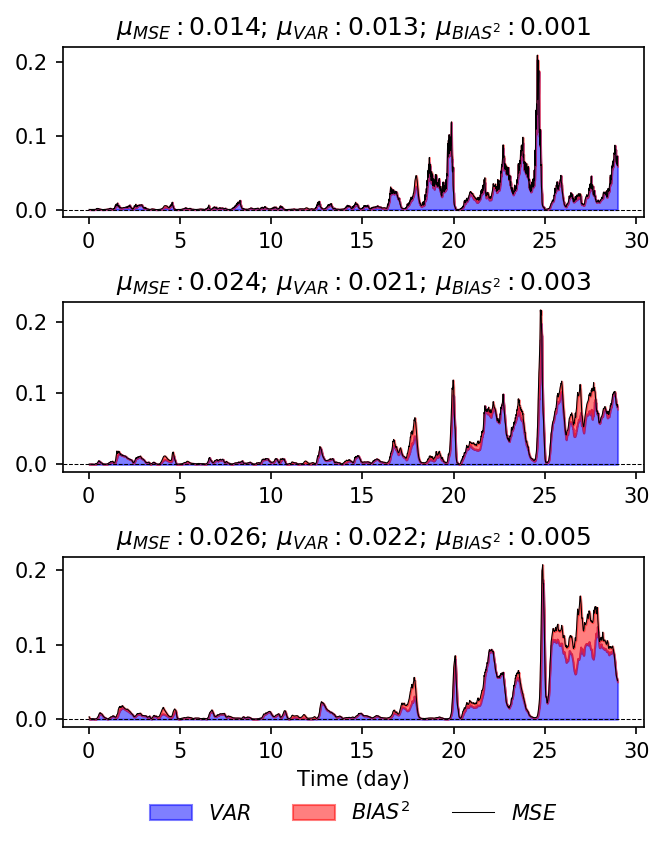

In [61]:
# Plot
obs_loc_set = dar1.obs_loc_set
_, nloc     = obs_loc_set.shape
fig = plt.figure(num=1, dpi=150, figsize=(5,6), constrained_layout=True)
gs = gridspec.GridSpec(nloc, 1, height_ratios=[1, 1, 1])        
axes, line1, line2, line3, var_set, bias_set, mse_set = plot_temperature_mse(dar1, posterior1, temp_times1, gs)     

for i in range(nloc):
    axes[i].set_title("$\mu_{MSE}: %.3f$; $\mu_{VAR}: %.3f$; $\mu_{BIAS^2}: %.3f$" % 
                      (np.mean(mse_set[i]),np.mean(var_set[i]),np.mean(bias_set[i])))

# Plot the legends
plt.subplots_adjust(hspace=0.5)
plt.legend((line1, line2, line3), ('$VAR$', '$BIAS^2$','$MSE$'), 
           frameon=False, ncol=3, loc="center", bbox_to_anchor=(0.5, -0.5))

# Plot the labels and titles
# axes[0].set_title("Posterior")
axes[-1].set_xlabel("Time (day)")
# for i in range(nloc):
#     axes[i].set_ylabel("Dimension z: \n %.2f (m)" % (obs_loc_set[2, i]))
# plt.savefig(os.path.join(fig_dir, app_dir_improved_name+"_temperature_mse.png"), dpi=150)

## Flow flux

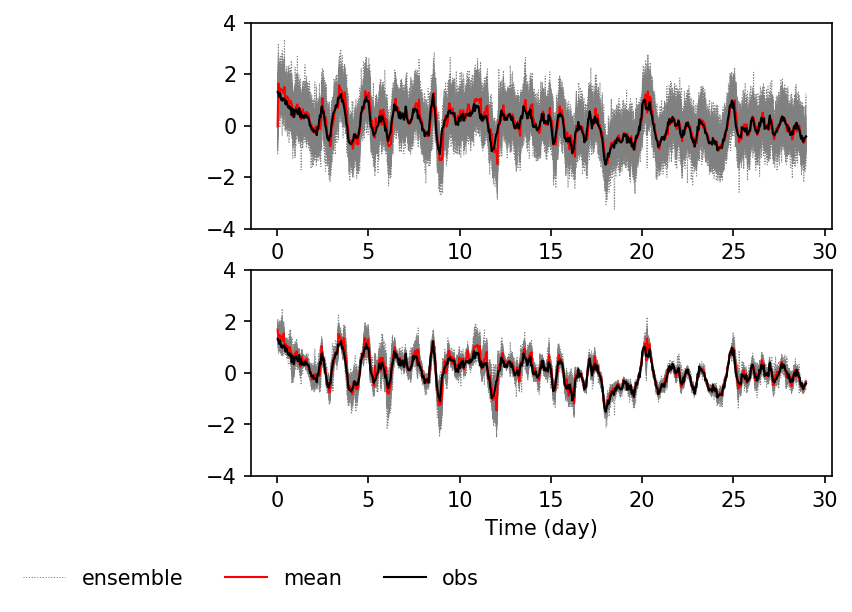

In [63]:
flux_file = os.path.join(app_dir_improved, "pflotran_input/flux_1d_new.csv")
fig = plt.figure(num=1,dpi=150, figsize=(5,4), constrained_layout=False)
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], figure=fig)
axes = np.empty(2, dtype=object)
axes[0] = plt.subplot(gs[0, 0])
axes[1] = plt.subplot(gs[1, 0], sharey=axes[0], sharex=axes[0])
# fig, axes = plt.subplots(1, 2, figsize=(8,3), dpi=150, constrained_layout=True)
dar1.compare_univar_spatial_average(var_name='FLOW_FLUX', true_file_name=flux_file, axes=axes, ylim=[-4, 4])
# axes[1].set_xlim([8,9.5])
plt.subplots_adjust(wspace=0.2)
# plt.savefig(os.path.join(fig_dir, app_dir_name+"_flowflux.png"), dpi=150, bbox_inches='tight')
# plt.savefig(os.path.join(fig_dir, app_dir_improved_name+"_flowflux_results.png"), dpi=150)

### bias and error

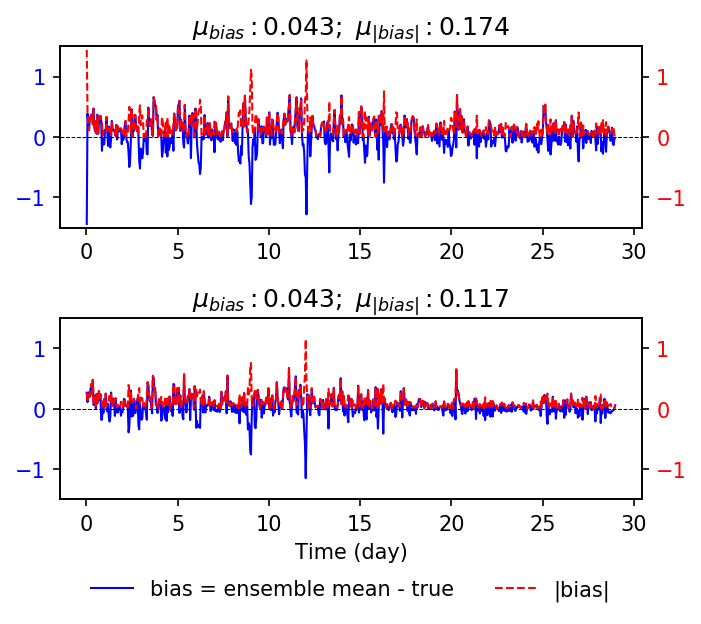

In [119]:
flux_file = os.path.join(app_dir_improved, "pflotran_input/flux_1d_new.csv")
fig = plt.figure(num=1,dpi=150, figsize=(5,4), constrained_layout=False)
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], figure=fig)
axes = np.empty(2, dtype=object)
axes[0] = plt.subplot(gs[0, 0])
axes[1] = plt.subplot(gs[1, 0], sharey=axes[0], sharex=axes[0])
# fig, axes = plt.subplots(1, 2, figsize=(8,3), dpi=150, constrained_layout=True)
axes, line1, line2, diff_mean_set = plot_flux_diff(dar1,flux_file,axes=axes,ylim=[-1.5, 1.5])
# axes[1].set_xlim([8,9.5])
for i in range(2):
    diff_mean = diff_mean_set[i]
    axes[i].set_title("$\mu_{bias}: %.3f;$ $\mu_{|bias|}: %.3f$" % 
                      (np.mean(diff_mean),np.mean(np.abs(diff_mean))))

# Plot the legends
# plt.legend(frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.9, -0.3))
plt.subplots_adjust(hspace=0.5)
plt.legend((line1, line2), ('bias = ensemble mean - true', '|bias|'), 
           frameon=False, ncol=2, loc="center", bbox_to_anchor=(0.5, -0.5))
# plt.savefig(os.path.join(fig_dir, app_dir_name+"_flowflux.png"), dpi=150, bbox_inches='tight')
# plt.savefig(os.path.join(fig_dir, app_dir_improved_name+"_flowflux_errorbias.png"), dpi=150)

### bias and variance

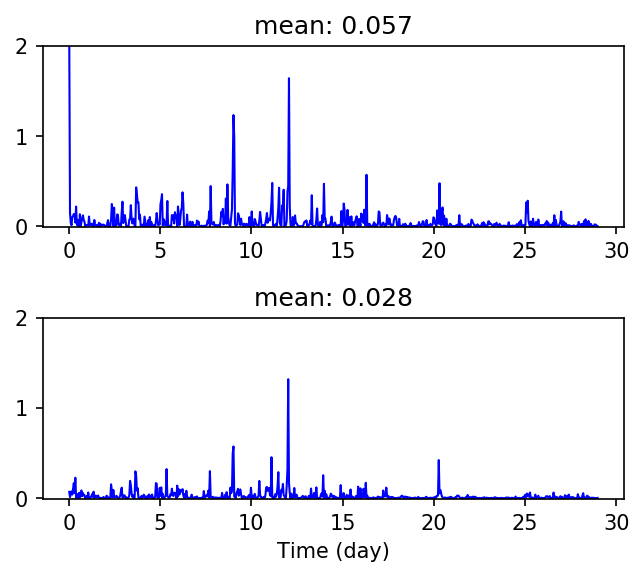

In [118]:
flux_file = os.path.join(app_dir_improved, "pflotran_input/flux_1d_new.csv")
fig = plt.figure(num=1,dpi=150, figsize=(5,4), constrained_layout=False)
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], figure=fig)
axes = np.empty(2, dtype=object)
axes[0] = plt.subplot(gs[0, 0])
axes[1] = plt.subplot(gs[1, 0], sharey=axes[0], sharex=axes[0])      
axes, line, bias_set = plot_flux_bias(dar1,flux_file,axes=axes,ylim=[-1.5, 1.5])

for i in range(2):
    axes[i].set_title("mean: %.3f" % (np.mean(bias_set[i])))

# Plot the legends
plt.subplots_adjust(hspace=0.5)
# plt.legend((line), ('|bias| = |ensemble mean - true|'), 
#            frameon=False, ncol=3, loc="center", bbox_to_anchor=(0.5, -0.5))

# Plot the labels and titles
# axes[0].set_title("Posterior")
axes[-1].set_xlabel("Time (day)")
for i in range(2):
    axes[i].set_ylim([-0.01, 2.])
# for i in range(nloc):
#     axes[i].set_ylabel("Dimension z: \n %.2f (m)" % (obs_loc_set[2, i]))
# plt.savefig(os.path.join(fig_dir, app_dir_improved_name+"_temperature_bias.png"), dpi=150)

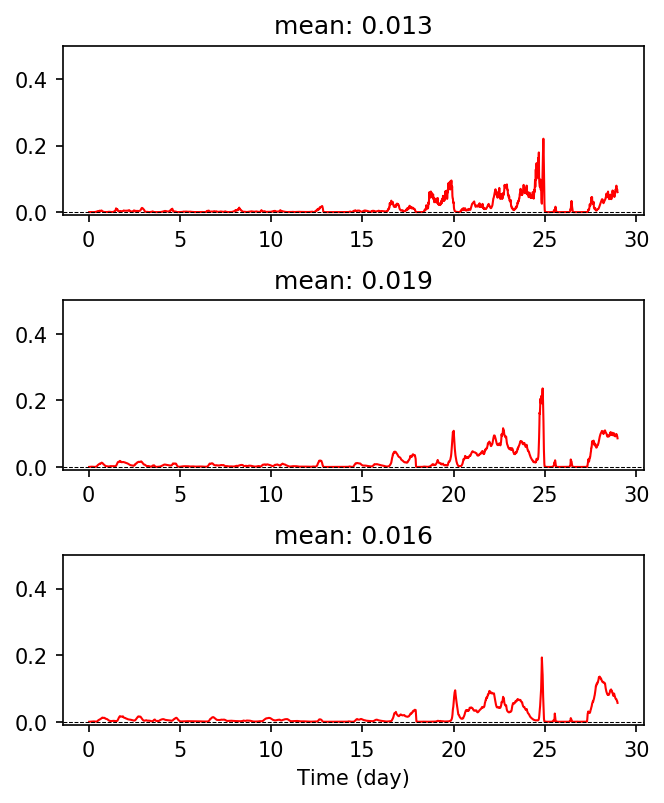

In [104]:
# Plot
obs_loc_set = dar2.obs_loc_set
_, nloc     = obs_loc_set.shape
fig = plt.figure(num=1, dpi=150, figsize=(5,6), constrained_layout=True)
gs = gridspec.GridSpec(nloc, 1, height_ratios=[1, 1, 1])        
axes, line, var_set = plot_temperature_variance(dar2, posterior2, temp_times2, gs)     

for i in range(nloc):
    axes[i].set_title("mean: %.3f" % (np.mean(var_set[i])))

# Plot the legends
plt.subplots_adjust(hspace=0.5)
# plt.legend((line), ('|bias| = |ensemble mean - true|'), 
#            frameon=False, ncol=3, loc="center", bbox_to_anchor=(0.5, -0.5))

# Plot the labels and titles
# axes[0].set_title("Posterior")
axes[-1].set_xlabel("Time (day)")
for i in range(nloc):
    axes[i].set_ylim([-0.01, 0.5])
# for i in range(nloc):
#     axes[i].set_ylabel("Dimension z: \n %.2f (m)" % (obs_loc_set[2, i]))
# plt.savefig(os.path.join(fig_dir, app_dir_improved_name+"_temperature_var.png"), dpi=150)

### MSE

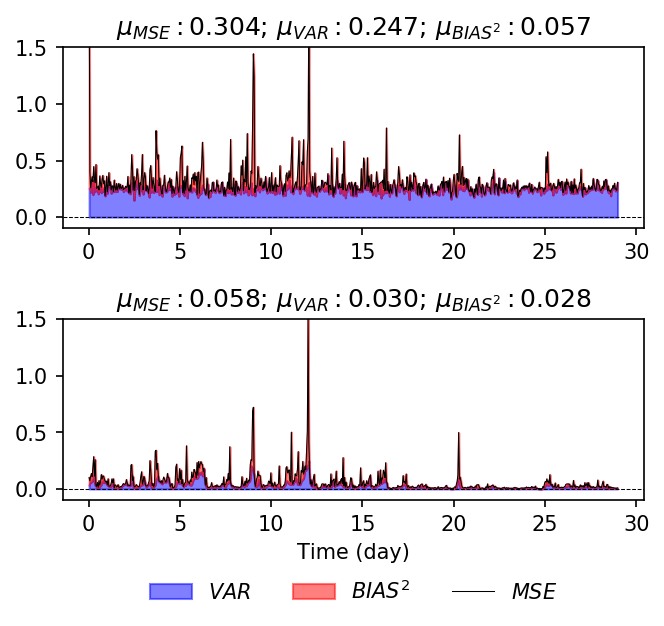

In [70]:
flux_file = os.path.join(app_dir_improved, "pflotran_input/flux_1d_new.csv")
fig = plt.figure(num=1,dpi=150, figsize=(5,4), constrained_layout=False)
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], figure=fig)
axes = np.empty(2, dtype=object)
axes[0] = plt.subplot(gs[0, 0])
axes[1] = plt.subplot(gs[1, 0], sharey=axes[0], sharex=axes[0])
# fig, axes = plt.subplots(1, 2, figsize=(8,3), dpi=150, constrained_layout=True)
axes, line1, line2, line3, var_set, bias_set, mse_set = plot_flux_mse(dar1,flux_file,axes=axes,ylim=[-.1, 1.5])
# axes[1].set_xlim([8,9.5])

for i in range(2):
    axes[i].set_title("$\mu_{MSE}: %.3f$; $\mu_{VAR}: %.3f$; $\mu_{BIAS^2}: %.3f$" % 
                      (np.mean(mse_set[i]),np.mean(var_set[i]),np.mean(bias_set[i])))

# Plot the legends
plt.subplots_adjust(hspace=0.5)
plt.legend((line1, line2, line3), ('$VAR$', '$BIAS^2$','$MSE$'), 
           frameon=False, ncol=3, loc="center", bbox_to_anchor=(0.5, -0.5))

# plt.savefig(os.path.join(fig_dir, app_dir_improved_name+"_flowflux_mse.png"), dpi=150)

# Results from the original DART

In [71]:
dar2 = DaResults(config_file_original)
dar2.obs_nc = os.path.join(app_dir_original, "pflotran_input/obs_true_pflotran_clipped.nc") # Put the true data instead of observation data
dar2.setup(from_concatenated=0)
nvar = dar2.nvar

## Visualize spatial average results

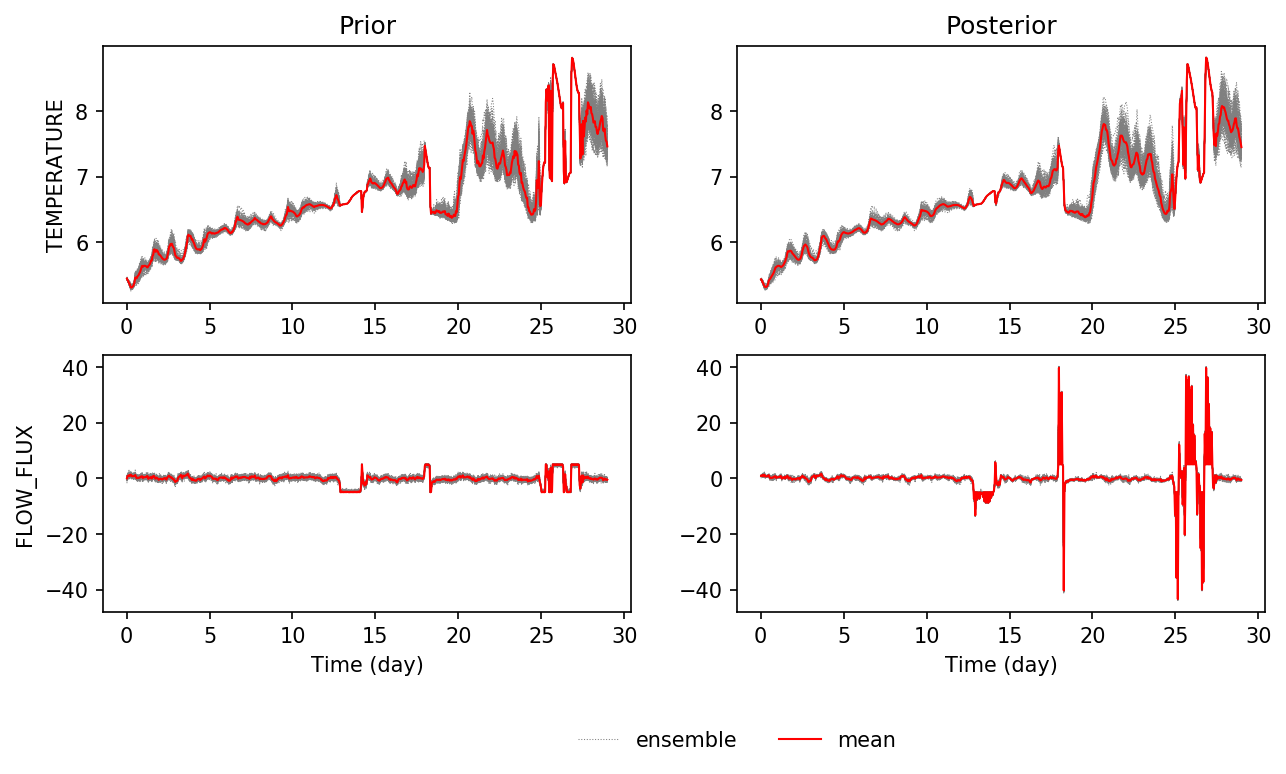

In [72]:
fig = plt.figure(num=1,dpi=150, figsize=(10,5), constrained_layout=True)
gs = gridspec.GridSpec(nvar, 2, width_ratios=[1, 1])
axes = np.empty([nvar, 2], dtype=object)
for i in range(nvar):
    axes[i, 0] = plt.subplot(gs[i, 0])
    axes[i, 1] = plt.subplot(gs[i, 1], sharey=axes[i, 0], sharex=axes[i, 0])
dar2.plot_spatial_average(axes)
# plt.savefig(os.path.join(fig_dir, app_dir_original_name+"_general_results.png"), dpi=150)

## Temperature (from HDF5 file)
Note that the HDF5 file contains model states in different time steps

In [73]:
# Get the posterior from the model output
pflotran_out2 = os.path.join(app_dir_original, "pflotran_output")
posterior_temp_from_h2 = os.path.join(pflotran_out2,'posterior_temperature_fromh5.npy')
posterior2, temp_times2 = get_temperature_posterior_fromh5(pflotran_out2, posterior_temp_from_h2, dar2.nens)
temp_times2 = temp_times2 - 7200./86400. # Get rid of the spinup time

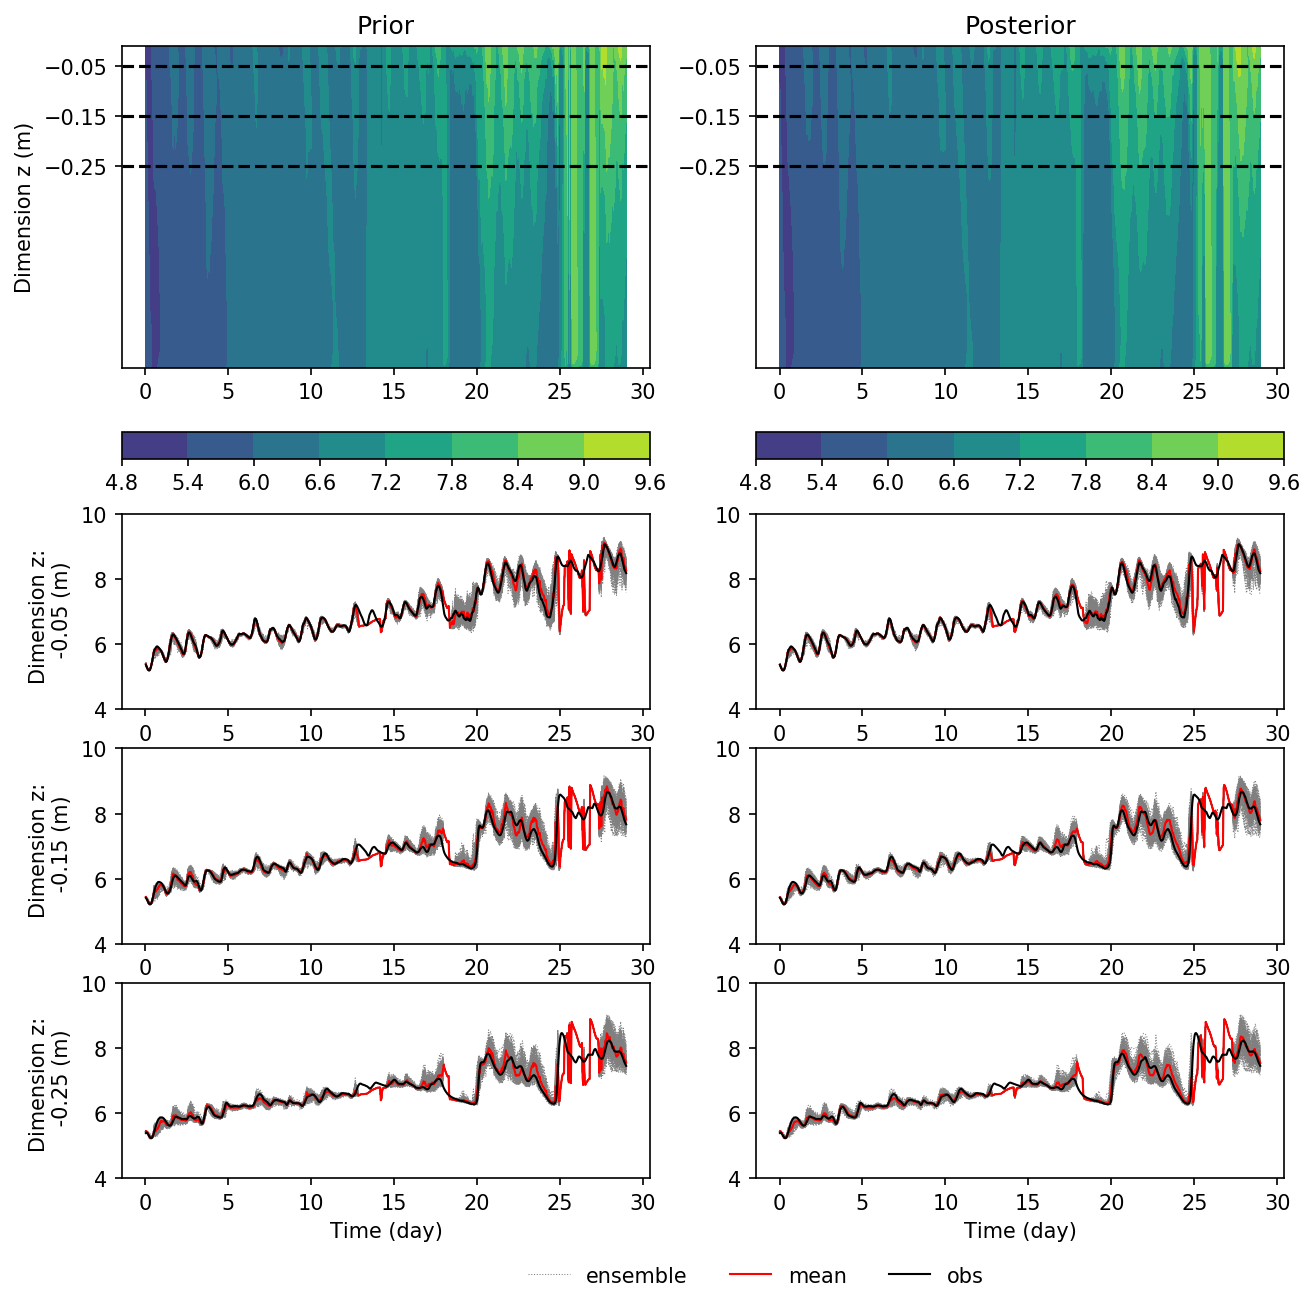

In [74]:
dar2.plot_oned_obs('TEMPERATURE', figsize=(10,10), dim_str='z', vmin=4, vmax=10, ylim=[4, 10])

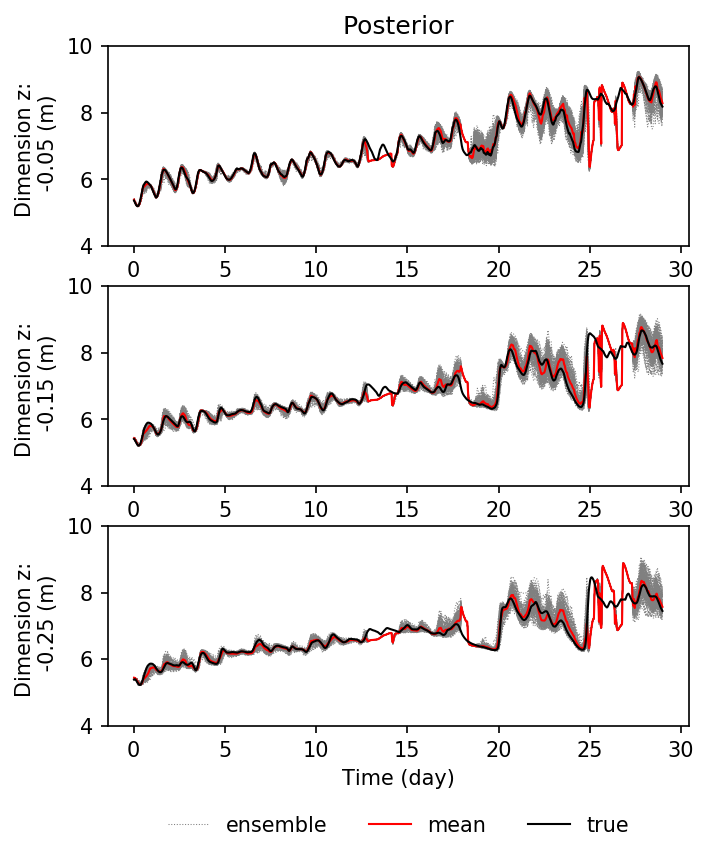

In [75]:
# Plot
obs_loc_set = dar2.obs_loc_set
_, nloc     = obs_loc_set.shape
fig = plt.figure(num=1, dpi=150, figsize=(5,6), constrained_layout=True)
gs = gridspec.GridSpec(nloc, 1, height_ratios=[1, 1, 1])        
axes, line1, line2, line3 = plot_temperature(dar2, posterior2, temp_times2, gs)
# Plot the legends
# plt.legend(frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.9, -0.3))
plt.legend((line1, line2, line3), ('ensemble', 'mean', 'true'), frameon=False, ncol=3, loc="center", bbox_to_anchor=(0.5, -0.5))

# Plot the labels and titles
axes[0].set_title("Posterior")
axes[-1].set_xlabel("Time (day)")
for i in range(nloc):
    axes[i].set_ylabel("Dimension z: \n %.2f (m)" % (obs_loc_set[2, i]))
# plt.savefig(os.path.join(fig_dir, app_dir_original_name+"_temperature_results.png"), dpi=150)

### bias and error

Text(0.5, 0, 'Time (day)')

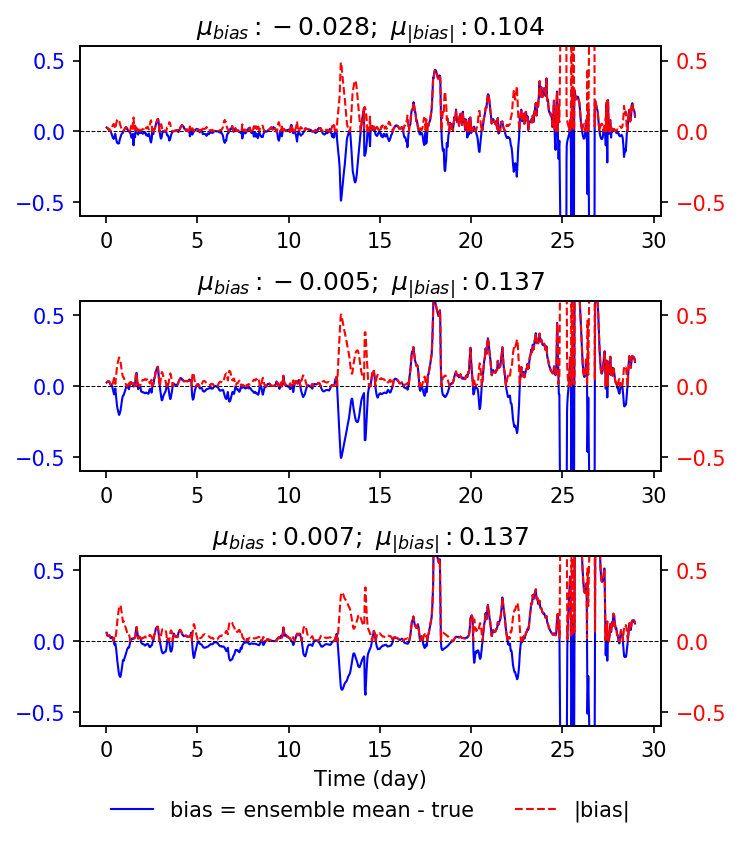

In [121]:
# Plot
obs_loc_set = dar2.obs_loc_set
_, nloc     = obs_loc_set.shape
fig = plt.figure(num=1, dpi=150, figsize=(5,6), constrained_layout=True)
gs = gridspec.GridSpec(nloc, 1, height_ratios=[1, 1, 1])        
axes, line1, line2, diff_mean_set = plot_temperature_diff(dar2, posterior2, temp_times2, gs)     

for i in range(nloc):
    diff_mean = diff_mean_set[i]
    axes[i].set_title("$\mu_{bias}: %.3f;$ $\mu_{|bias|}: %.3f$" % 
                      (np.mean(diff_mean),np.mean(np.abs(diff_mean))))

# Plot the legends
# plt.legend(frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.9, -0.3))
plt.subplots_adjust(hspace=0.5)
plt.legend((line1, line2), ('bias = ensemble mean - true', '|bias|'), 
           frameon=False, ncol=3, loc="center", bbox_to_anchor=(0.5, -0.5))

# Plot the labels and titles
# axes[0].set_title("Posterior")
axes[-1].set_xlabel("Time (day)")
# for i in range(nloc):
#     axes[i].set_ylabel("Dimension z: \n %.2f (m)" % (obs_loc_set[2, i]))
# plt.savefig(os.path.join(fig_dir, app_dir_original_name+"_temperature_errorbias.png"), dpi=150)

### bias and variance

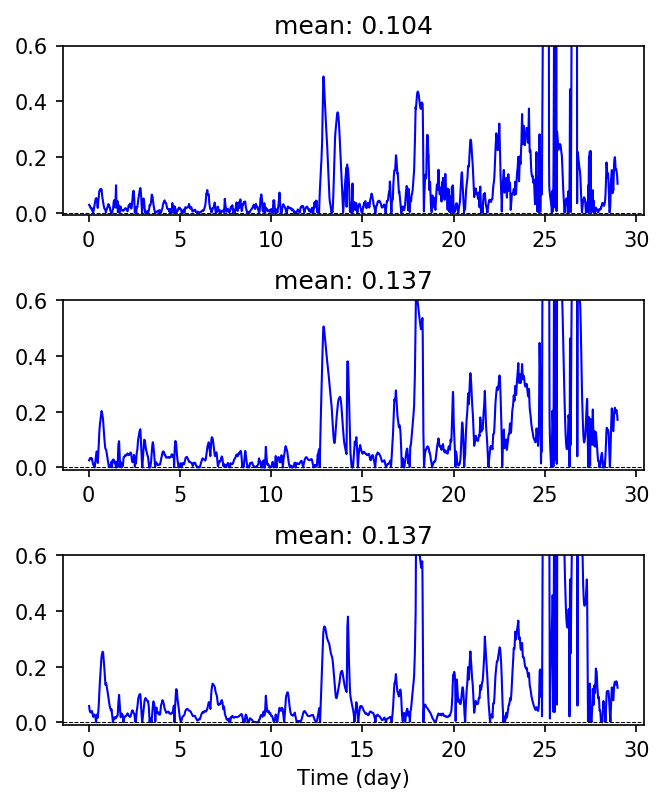

In [108]:
# Plot
obs_loc_set = dar2.obs_loc_set
_, nloc     = obs_loc_set.shape
fig = plt.figure(num=1, dpi=150, figsize=(5,6), constrained_layout=True)
gs = gridspec.GridSpec(nloc, 1, height_ratios=[1, 1, 1])        
axes, line, bias_set = plot_temperature_bias(dar2, posterior2, temp_times2, gs)     

for i in range(nloc):
    axes[i].set_title("mean: %.3f" % (np.mean(bias_set[i])))

# Plot the legends
plt.subplots_adjust(hspace=0.5)
# plt.legend((line), ('|bias| = |ensemble mean - true|'), 
#            frameon=False, ncol=3, loc="center", bbox_to_anchor=(0.5, -0.5))

# Plot the labels and titles
# axes[0].set_title("Posterior")
axes[-1].set_xlabel("Time (day)")
for i in range(nloc):
    axes[i].set_ylim([-0.01, .6])
# for i in range(nloc):
#     axes[i].set_ylabel("Dimension z: \n %.2f (m)" % (obs_loc_set[2, i]))
# plt.savefig(os.path.join(fig_dir, app_dir_improved_name+"_temperature_bias.png"), dpi=150)

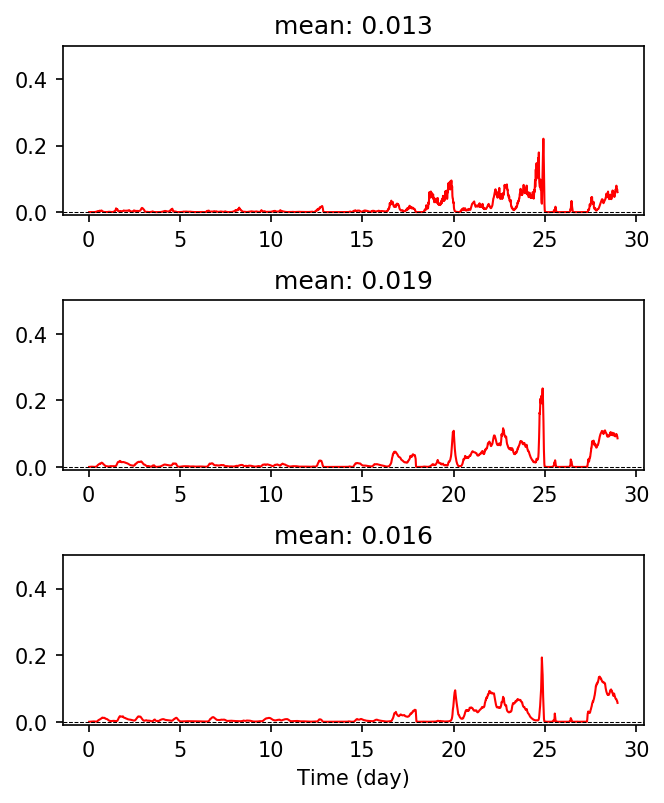

In [110]:
# Plot
obs_loc_set = dar2.obs_loc_set
_, nloc     = obs_loc_set.shape
fig = plt.figure(num=1, dpi=150, figsize=(5,6), constrained_layout=True)
gs = gridspec.GridSpec(nloc, 1, height_ratios=[1, 1, 1])        
axes, line, var_set = plot_temperature_variance(dar2, posterior2, temp_times2, gs)     

for i in range(nloc):
    axes[i].set_title("mean: %.3f" % (np.mean(var_set[i])))

# Plot the legends
plt.subplots_adjust(hspace=0.5)
# plt.legend((line), ('|bias| = |ensemble mean - true|'), 
#            frameon=False, ncol=3, loc="center", bbox_to_anchor=(0.5, -0.5))

# Plot the labels and titles
# axes[0].set_title("Posterior")
axes[-1].set_xlabel("Time (day)")
for i in range(nloc):
    axes[i].set_ylim([-0.01, 0.5])
# for i in range(nloc):
#     axes[i].set_ylabel("Dimension z: \n %.2f (m)" % (obs_loc_set[2, i]))
# plt.savefig(os.path.join(fig_dir, app_dir_improved_name+"_temperature_var.png"), dpi=150)

### MSE

Text(0.5, 0, 'Time (day)')

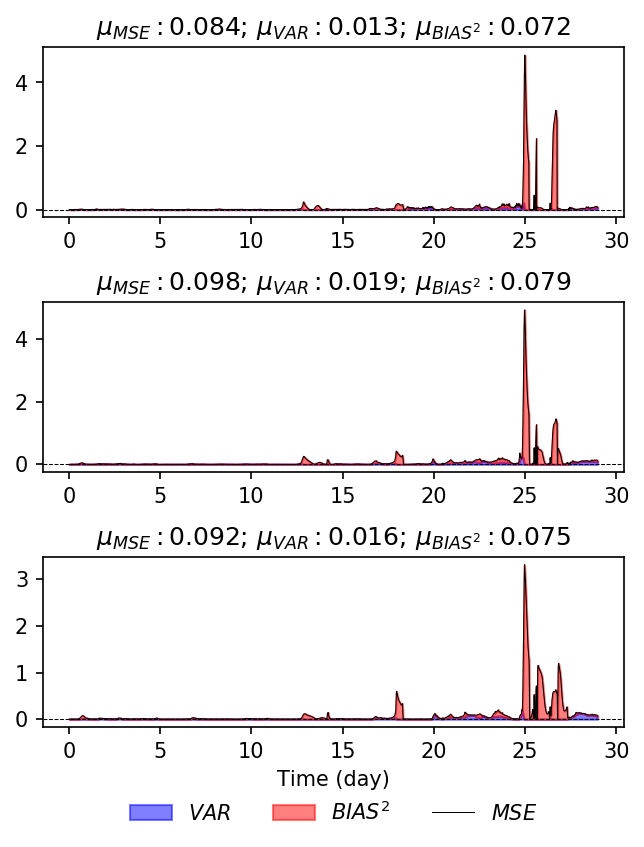

In [77]:
# Plot
obs_loc_set = dar2.obs_loc_set
_, nloc     = obs_loc_set.shape
fig = plt.figure(num=1, dpi=150, figsize=(5,6), constrained_layout=True)
gs = gridspec.GridSpec(nloc, 1, height_ratios=[1, 1, 1])        
axes, line1, line2, line3, var_set, bias_set, mse_set = plot_temperature_mse(dar2, posterior2, temp_times2, gs)     

for i in range(nloc):
    axes[i].set_title("$\mu_{MSE}: %.3f$; $\mu_{VAR}: %.3f$; $\mu_{BIAS^2}: %.3f$" % 
                      (np.mean(mse_set[i]),np.mean(var_set[i]),np.mean(bias_set[i])))

# Plot the legends
plt.subplots_adjust(hspace=0.5)
plt.legend((line1, line2, line3), ('$VAR$', '$BIAS^2$','$MSE$'), 
           frameon=False, ncol=3, loc="center", bbox_to_anchor=(0.5, -0.5))

# Plot the labels and titles
# axes[0].set_title("Posterior")
axes[-1].set_xlabel("Time (day)")
# for i in range(nloc):
#     axes[i].set_ylabel("Dimension z: \n %.2f (m)" % (obs_loc_set[2, i]))
# plt.savefig(os.path.join(fig_dir, app_dir_original_name+"_temperature_mse.png"), dpi=150)

## Flow flux

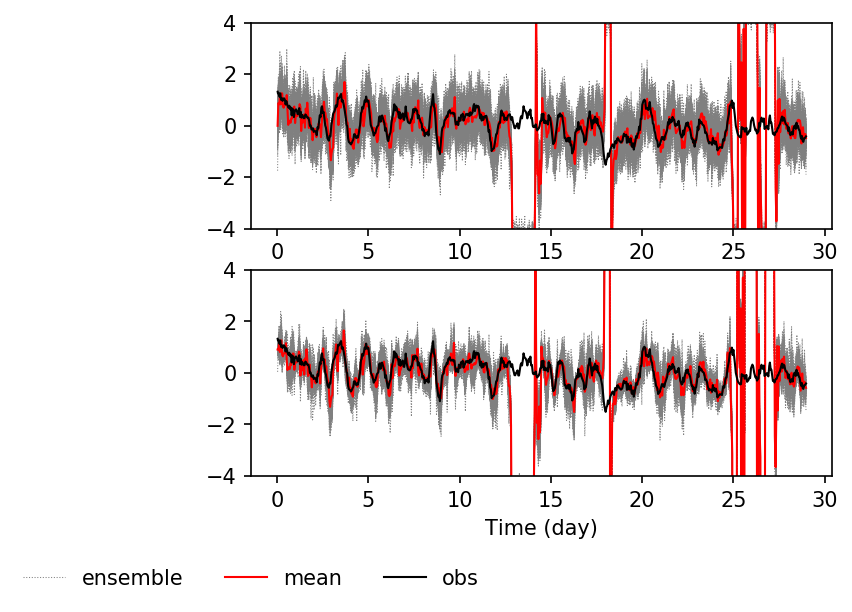

In [78]:
flux_file = os.path.join(app_dir_improved, "pflotran_input/flux_1d_new.csv")
fig = plt.figure(num=1,dpi=150, figsize=(5,4), constrained_layout=False)
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], figure=fig)
axes = np.empty(2, dtype=object)
axes[0] = plt.subplot(gs[0, 0])
axes[1] = plt.subplot(gs[1, 0], sharey=axes[0], sharex=axes[0])
# fig, axes = plt.subplots(1, 2, figsize=(8,3), dpi=150, constrained_layout=True)
dar2.compare_univar_spatial_average(var_name='FLOW_FLUX', true_file_name=flux_file, axes=axes, ylim=[-4, 4])
# axes[1].set_xlim([8,9.5])
plt.subplots_adjust(wspace=0.2)
# plt.savefig(os.path.join(fig_dir, app_dir_original_name+"_flowflux_results.png"), dpi=150)

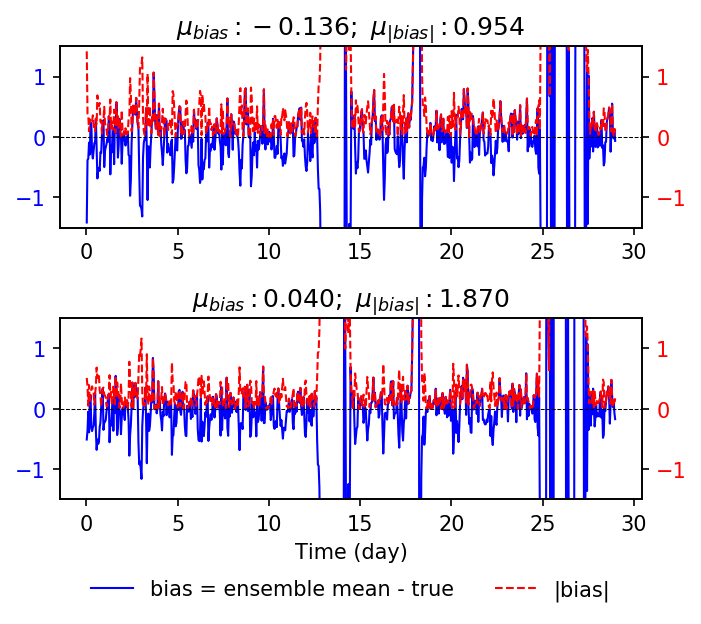

In [122]:
flux_file = os.path.join(app_dir_improved, "pflotran_input/flux_1d_new.csv")
fig = plt.figure(num=1,dpi=150, figsize=(5,4), constrained_layout=False)
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], figure=fig)
axes = np.empty(2, dtype=object)
axes[0] = plt.subplot(gs[0, 0])
axes[1] = plt.subplot(gs[1, 0], sharey=axes[0], sharex=axes[0])
# fig, axes = plt.subplots(1, 2, figsize=(8,3), dpi=150, constrained_layout=True)
axes, line1, line2, diff_mean_set = plot_flux_diff(dar2,flux_file,axes=axes,ylim=[-1.5, 1.5])
# axes[1].set_xlim([8,9.5])
for i in range(2):
    diff_mean = diff_mean_set[i]
    axes[i].set_title("$\mu_{bias}: %.3f;$ $\mu_{|bias|}: %.3f$" % 
                      (np.mean(diff_mean),np.mean(np.abs(diff_mean))))

# Plot the legends
# plt.legend(frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.9, -0.3))
plt.subplots_adjust(hspace=0.5)
plt.legend((line1, line2), ('bias = ensemble mean - true', '|bias|'), 
           frameon=False, ncol=2, loc="center", bbox_to_anchor=(0.5, -0.5))
# plt.savefig(os.path.join(fig_dir, app_dir_name+"_flowflux.png"), dpi=150, bbox_inches='tight')
# plt.savefig(os.path.join(fig_dir, app_dir_original_name+"_flowflux_errorbias.png"), dpi=150)

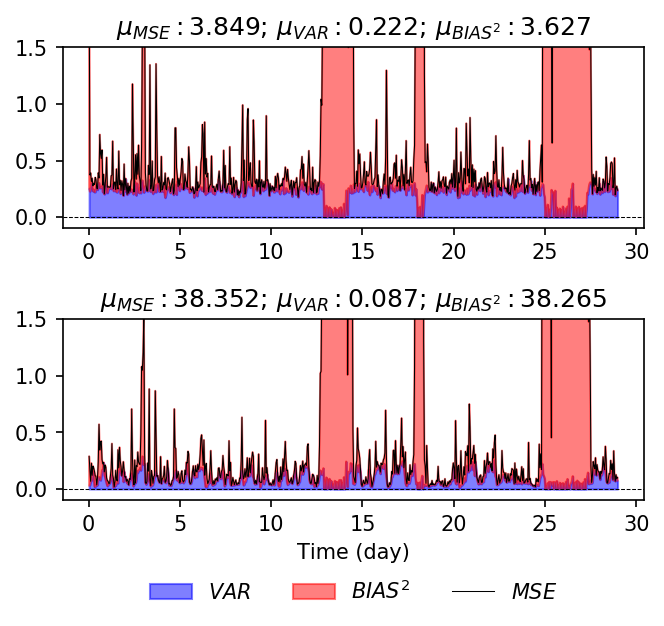

In [80]:
flux_file = os.path.join(app_dir_improved, "pflotran_input/flux_1d_new.csv")
fig = plt.figure(num=1,dpi=150, figsize=(5,4), constrained_layout=False)
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], figure=fig)
axes = np.empty(2, dtype=object)
axes[0] = plt.subplot(gs[0, 0])
axes[1] = plt.subplot(gs[1, 0], sharey=axes[0], sharex=axes[0])
# fig, axes = plt.subplots(1, 2, figsize=(8,3), dpi=150, constrained_layout=True)
axes, line1, line2, line3, var_set, bias_set, mse_set = plot_flux_mse(dar2,flux_file,axes=axes,ylim=[-.1, 1.5])
# axes[1].set_xlim([8,9.5])

for i in range(2):
    axes[i].set_title("$\mu_{MSE}: %.3f$; $\mu_{VAR}: %.3f$; $\mu_{BIAS^2}: %.3f$" % 
                      (np.mean(mse_set[i]),np.mean(var_set[i]),np.mean(bias_set[i])))

# Plot the legends
plt.subplots_adjust(hspace=0.5)
plt.legend((line1, line2, line3), ('$VAR$', '$BIAS^2$','$MSE$'), 
           frameon=False, ncol=3, loc="center", bbox_to_anchor=(0.5, -0.5))

# plt.savefig(os.path.join(fig_dir, app_dir_original_name+"_flowflux_mse.png"), dpi=150)

# Results generated from the original sequential ensemble smoother
Compare DART-generated EnKF/ES results with Kewei's result.

## Flow flux

In [124]:
# Get the Kewei's results
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from datetime import datetime

assim_start_me, assim_start_enks = dar1.assim_start_time, "2017-04-01 02:00:00"
flux_posterior_file = os.path.join(app_dir_kewei, "flux_Kewei_posterior_woflowdir_mda1_noise005_abs.txt")
flux_prior_file = os.path.join(app_dir_kewei, "flux_Kewei_prior_woflowdir_mda1_noise005_abs.txt")
true_set = pd.read_csv(flux_file)
prior, posterior = np.loadtxt(flux_prior_file), np.loadtxt(flux_posterior_file)
_, nens = prior.shape
assim_window = 1. / 24.  # Kewei's assimilation window (1hr)
fraction = int(assim_window / dar1.assim_window)

In [125]:
# Get the time index
model_start_time, model_end_time = dar1.model_start_time, dar1.model_end_time
ref_time           = datetime.strptime(assim_start_me, "%Y-%m-%d %H:%M:%S")
true_set_raw_time  = true_set.iloc[:, 0].values
true_set_dates     = np.array([datetime.strptime(t, '%m/%d/%Y %H:%M') for t in true_set_raw_time])
dates_ref          = [t-ref_time for t in true_set_dates]
true_set_time      = np.array([t.days+float(t.seconds)/86400. for t in dates_ref])
true               = true_set.iloc[:, 1].values
true_set_used_ind  = (true_set_time >= model_start_time) & (true_set_time <= model_end_time)
true_set_time_used = true_set_time[true_set_used_ind]
true_set_used      = true[true_set_used_ind]

# ref_time_enks      = datetime.strptime(assim_start_enks, "%Y-%m-%d %H:%M:%S")
# enks_set_time = true_set_time[true_set_dates > ref_time_enks]
# enks_ind  = (enks_set_time >= model_start_time) & (enks_set_time <= model_end_time)
model_time_list = [dar1.model_time_list[i] for i in range(len(dar1.model_time_list))  if i % fraction == 0]
ntime = len(model_time_list)
analyzed_prior_ens = prior[:ntime,:].T
analyzed_posterior_ens = posterior[1:1+ntime, :].T

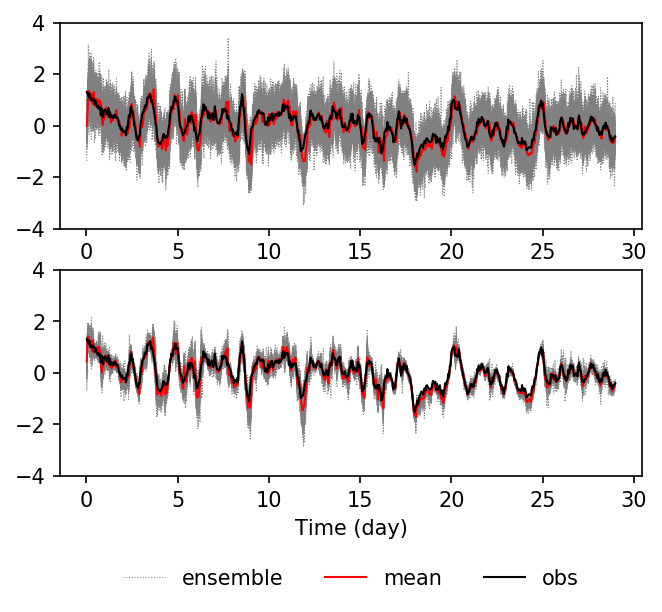

In [126]:
# Plot
ylim=[-4, 4]
fig = plt.figure(num=1, dpi=150,figsize=(5, 4), constrained_layout=True)
gs  = gridspec.GridSpec(2, 1, height_ratios=[1, 1])
# Plot the prior
ax1 = plt.subplot(gs[0, 0])
for j in range(nens):
    prior_ens = analyzed_prior_ens[j, :]
    line1, = ax1.plot(model_time_list, prior_ens, color='grey',
                      linewidth=0.5, linestyle=':', label='ensemble')
prior_mean = np.mean(analyzed_prior_ens, axis=(0))
line2, = ax1.plot(model_time_list, prior_mean, color='red',
                  linewidth=1, label='mean')
line3, = ax1.plot(true_set_time_used, true_set_used, color='black',
                  linewidth=1, label='obs')

# Plot the posterior
ax2 = plt.subplot(gs[1, 0])
for j in range(nens):
    posterior_ens = analyzed_posterior_ens[j, :]
    line1, = ax2.plot(model_time_list, posterior_ens, color='grey',
                      linewidth=0.5, linestyle=':', label='ensemble')
posterior_mean = np.mean(analyzed_posterior_ens, axis=(0))
line2, = ax2.plot(model_time_list, posterior_mean, color='red',
                  linewidth=1, label='mean')
line3, = ax2.plot(true_set_time_used, true_set_used, color='black',
                  linewidth=1, label='obs')

# Plot the legends
plt.legend((line1, line2, line3), ('ensemble', 'mean', 'obs'),
           frameon=False, ncol=3, loc="center", bbox_to_anchor=(0.5, -0.5))

# Plot the labels and titles
# ax1.set_title("Prior ({} from Kewei) \n assimilation window: 1hr".format('FLOW_FLUX'))
# ax2.set_title("Posterior ({} from Kewei) \n assimilation window: 1hr".format('FLOW_FLUX'))
ax1.set_xlabel("Time (day)")
ax2.set_xlabel("Time (day)")
ax1.set_ylim(ylim)
ax2.set_ylim(ylim);
# ax2.set_xlim([11, 13])
# plt.savefig(os.path.join(fig_dir, app_dir_kewei_name+"_flowflux_results.png"), dpi=150)

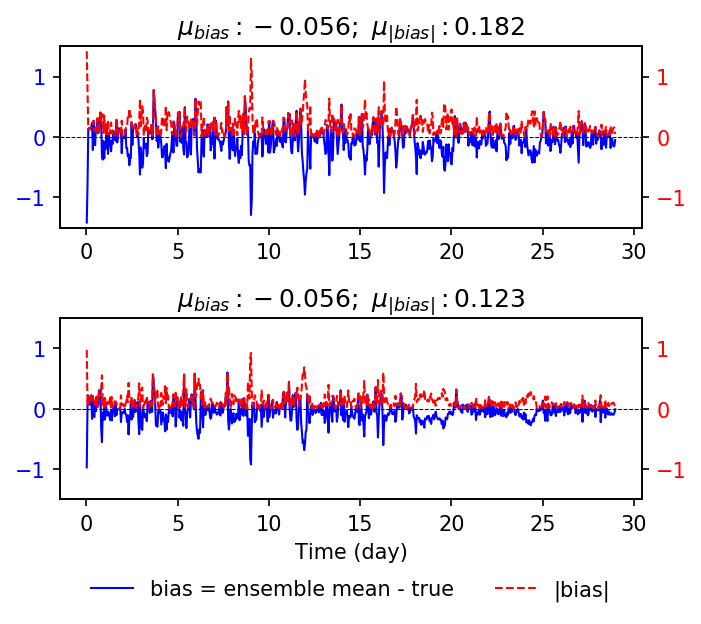

In [128]:
# Plot
# Compute the temporal averaged true values
model_time_offset = 1800./86400.
true_set_used_ave = [np.mean(true[(true_set_time >  (model_time_list[i-1]+model_time_offset)) & 
                                  (true_set_time <= (model_time_list[i]+model_time_offset))]) 
#                      if i != 0 else np.mean(true[(true_set_time >  (model_time_list[i]-model_time_offset)) & 
#                                                  (true_set_time <= (model_time_list[i]+model_time_offset))])
                     if i != 0 else np.mean(true[true_set_time <= (model_time_list[i]+model_time_offset)])
                     for i in range(len(model_time_list))] 

# # Get the difference between the estimated and the true for each realization
# diff      = analyzed_posterior_ens - true_set_used_ave
# diff_mean = np.mean(diff, axis=0)
# diff_std  = np.std(diff, axis=0)

# # Plot the posterior
# ax.plot(model_time_list[:], diff_mean, color='blue', linewidth=0.5, label='mean of the difference')
# ax.fill_between(model_time_list[:], diff_mean-diff_std, diff_mean+diff_std, color='blue', alpha=0.1)
# ax.axhline(y=0, color='black', linestyle='--')

fig = plt.figure(num=1,dpi=150, figsize=(5,4), constrained_layout=True)
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], figure=fig)

# Plot the prior
ax1 = plt.subplot(gs[0, 0])
# Plot the error
diff = np.zeros([ntime, nens])
for j in range(nens):
    diff[:, j] = analyzed_prior_ens[j,:] - true_set_used_ave
diff_mean = np.mean(diff, axis=1)
diff_mean_abs = np.abs(diff_mean)
diff_std  = np.std(diff, axis=1)
line1,=ax1.plot(model_time_list, diff_mean, color='blue', linewidth=1, label='mean')
ax1.axhline(y=0,color='k',linestyle='--',linewidth=.5)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim([-1.5,1.5])
# Plot the bias
ax12 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax12.tick_params(axis='y', labelcolor='red')
ax12.set_ylim([-1.5,1.5])
line2,=ax12.plot(model_time_list, diff_mean_abs, color='red', linestyle='--', linewidth=1, label='mean') 
ax1.set_title("$\mu_{bias}: %.3f;$ $\mu_{|bias|}: %.3f$" % (np.mean(diff_mean),np.mean(np.abs(diff_mean))))

# Plot the posterior
ax2 = plt.subplot(gs[1, 0], sharey=axes[0], sharex=axes[0])
# Plot the error
diff = np.zeros([ntime, nens])
for j in range(nens):
    diff[:, j] = analyzed_posterior_ens[j,:] - true_set_used_ave
diff_mean = np.mean(diff, axis=1)
diff_mean_abs = np.abs(diff_mean)
diff_std  = np.std(diff, axis=1)
line1,=ax2.plot(model_time_list, diff_mean, color='blue', linewidth=1, label='mean')
ax2.axhline(y=0,color='k',linestyle='--',linewidth=.5)
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim([-1.5,1.5])
# Plot the bias
ax22 = ax2.twinx()  # instantiate a second axes that shares the same x-axis
ax22.tick_params(axis='y', labelcolor='red')
ax22.set_ylim([-1.5,1.5])
line2,=ax22.plot(model_time_list, diff_mean_abs, color='red', linestyle='--', linewidth=1, label='mean')    
ax2.set_title("$\mu_{bias}: %.3f;$ $\mu_{|bias|}: %.3f$" % (np.mean(diff_mean),np.mean(np.abs(diff_mean))))

# # Plot the labels and titles
ax2.set_xlabel("Time (day)");

# Plot the legends
# plt.legend(frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.9, -0.3))
plt.subplots_adjust(hspace=0.5)
plt.legend((line1, line2), ('bias = ensemble mean - true', '|bias|'), 
           frameon=False, ncol=2, loc="center", bbox_to_anchor=(0.5, -0.5))

# plt.savefig(os.path.join(fig_dir, app_dir_kewei_name+"_flowflux_errorbias.png"), dpi=150)

(-1.8, 1.8)

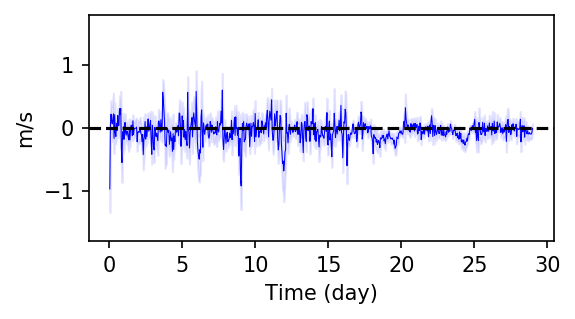

In [32]:
# Plot
_, ax = plt.subplots(1, 1, figsize=(4,2), dpi=150)

# Compute the temporal averaged true values
# true_set_used_ave = [true[true_set_time<=model_time_list[i]][-1] 
#                      for i in range(len(model_time_list))]
model_time_offset = 1800./86400.
true_set_used_ave = [np.mean(true[(true_set_time >  (model_time_list[i-1]+model_time_offset)) & 
                                  (true_set_time <= (model_time_list[i]+model_time_offset))]) 
#                      if i != 0 else np.mean(true[(true_set_time >  (model_time_list[i]-model_time_offset)) & 
#                                                  (true_set_time <= (model_time_list[i]+model_time_offset))])
                     if i != 0 else np.mean(true[true_set_time <= (model_time_list[i]+model_time_offset)])
                     for i in range(len(model_time_list))] 

# Get the difference between the estimated and the true for each realization
diff      = analyzed_posterior_ens - true_set_used_ave
diff_mean = np.mean(diff, axis=0)
diff_std  = np.std(diff, axis=0)

# Plot the posterior
ax.plot(model_time_list[:], diff_mean, color='blue', linewidth=0.5, label='mean of the difference')
ax.fill_between(model_time_list[:], diff_mean-diff_std, diff_mean+diff_std, color='blue', alpha=0.1)
ax.axhline(y=0, color='black', linestyle='--')

# Plot the labels and titles
ax.set_xlabel("Time (day)")
# ax.set_ylabel("ensemble mean - the true")
ax.set_ylabel("m/s")
ax.set_ylim([-1.8, 1.8])
# # Plot the posterior
# line, = ax.plot(model_time_list, diff_mean, color='red',
#                   linewidth=1, label='mean of the difference')
# ax.axhline(y=0, color='red', linestyle='--')
# ax2 = ax.twinx()
# line2, = ax2.plot(model_time_list, diff_std, color='blue',
#                   linewidth=1, label='std of the difference')
# ax2.axhline(y=0.2, color='blue', linestyle='--')

# # Plot the labels and titles
# ax.set_xlabel("Time (day)")
# ax.set_ylabel("mean of the difference ({})".format('m/s'), color='red')
# ax.tick_params(axis='y', labelcolor='red')
# ax2.set_ylabel("std of the difference ({})".format('m/s'), color='blue')
# ax2.tick_params(axis='y', labelcolor='blue')
# ax.set_ylim([-1.5,0.75])
# ax2.set_ylim([0., 1])

## Temperature

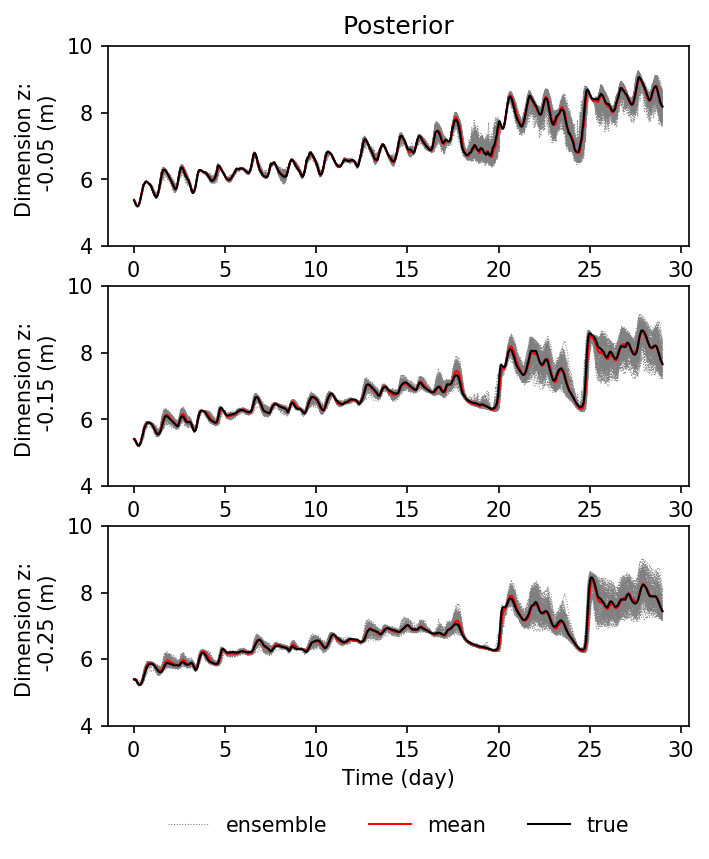

In [129]:
# Get the parameter
assim_start_me, assim_start_enks = dar1.assim_start_time, "2017-04-01 02:00:00"
# assim_start_me, assim_start_enks = dar1.assim_start_time, "2017-04-01 02:24:00"
temp_posterior_file = os.path.join(app_dir_kewei, "temp_Kewei_posterior_woflowdir_mda1_noise005_abs.txt")

posterior = np.loadtxt(temp_posterior_file)
# posterior = np.delete(posterior, np.arange(0, posterior.shape[0], 13), axis=0)
# a=np.arange(0, posterior.shape[0], 39)
# b=np.arange(1, posterior.shape[0], 39)
# c=np.arange(2, posterior.shape[0], 39)
# posterior = np.delete(posterior, np.concatenate([a,b,c]), axis=0)
_, nens = posterior.shape

obs_set               = dar1.obs_set
pflotran_var_set      = dar1.pflotran_var_set
# model_time_list       = dar1.model_time_list
# model_time_dates_list = dar1.model_time_dates_list
obs_time_set_used     = dar1.obs_time_set_used
obs_value_set_used    = dar1.obs_value_set_used
obs_loc_set           = dar1.obs_loc_set

ntime = len(obs_time_set_used)

# model_time_list2 = np.arange(model_time_list[0], model_time_list[-1], 300./86400)
# spinup_dt_num = int(3600*2/300)
spinup_dt_num = int(86400*0.1/300)
# posterior = posterior[3*spinup_dt_num:,:]
# posterior = posterior[:(len(model_time_list2))*3,:]
model_time_list = np.arange(0, posterior.shape[0]/3*300./86400, 300./86400)
model_time_list_used = model_time_list[(model_time_list>=obs_time_set_used[0]-0.000001)&
                                       (model_time_list<=obs_time_set_used[-1])]
# model_time_list = np.arange(0, len(obs_time_set_used)*300./86400, 300./86400)
posterior = posterior[:(len(model_time_list))*3,:]
posterior_set = [posterior[::3, :], posterior[1::3, :], posterior[2::3, :]]

xloc_set, yloc_set, zloc_set = dar1.x_loc, dar1.y_loc, dar1.z_loc

# Get the locations associated with this observation variable
_, nloc = obs_loc_set.shape
# nvar_obs = len(obs_set)

# Plot
fig = plt.figure(num=1, dpi=150, figsize=(5,6), constrained_layout=True)
gs = gridspec.GridSpec(nloc, 1, height_ratios=[1, 1, 1])

# Define axes array
axes = np.empty(nloc, dtype=object)

##############################
# Plot the temporal evolution of the ensemble, the mean, and the observation
# at each observed location
for i in range(nloc):
    posterior_current = posterior_set[i]
    posterior_current = posterior_current[(model_time_list>=obs_time_set_used[0]-0.000001)&
                                          (model_time_list<=obs_time_set_used[-1])]
    ax1 = plt.subplot(gs[i])
    for j in range(nens):
        posterior_ens = posterior_current[:, j]
        line1, = ax1.plot(model_time_list_used, posterior_ens, color='grey', linewidth=0.5, linestyle=':', label='ensemble')
    posterior_mean = np.mean(posterior_current, axis=(1))
#     posterior_mean2 = posterior_mean
    
    # Plot the posterior
    line2, = ax1.plot(model_time_list_used, posterior_mean, color='red', linewidth=1, label='mean')
    obs_used = obs_value_set_used['TEMPERATURE'][i, :]
    line3, = ax1.plot(obs_time_set_used, obs_used, color='black', linewidth=1, label='obs')
    ax1.set_ylim([4, 10])

    axes[i] = ax1

# Plot the legends
# plt.legend(frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.9, -0.3))
plt.legend((line1, line2, line3), ('ensemble', 'mean', 'true'), frameon=False, ncol=3, loc="center", bbox_to_anchor=(0.5, -0.5))

# Plot the labels and titles
axes[0].set_title("Posterior")
axes[-1].set_xlabel("Time (day)")
for i in range(nloc):
    axes[i].set_ylabel("Dimension z: \n %.2f (m)" % (obs_loc_set[2, i]))

# plt.savefig(os.path.join(fig_dir, app_dir_kewei_name+"_temperature_results.png"), dpi=150)

Text(0.5, 0, 'Time (day)')

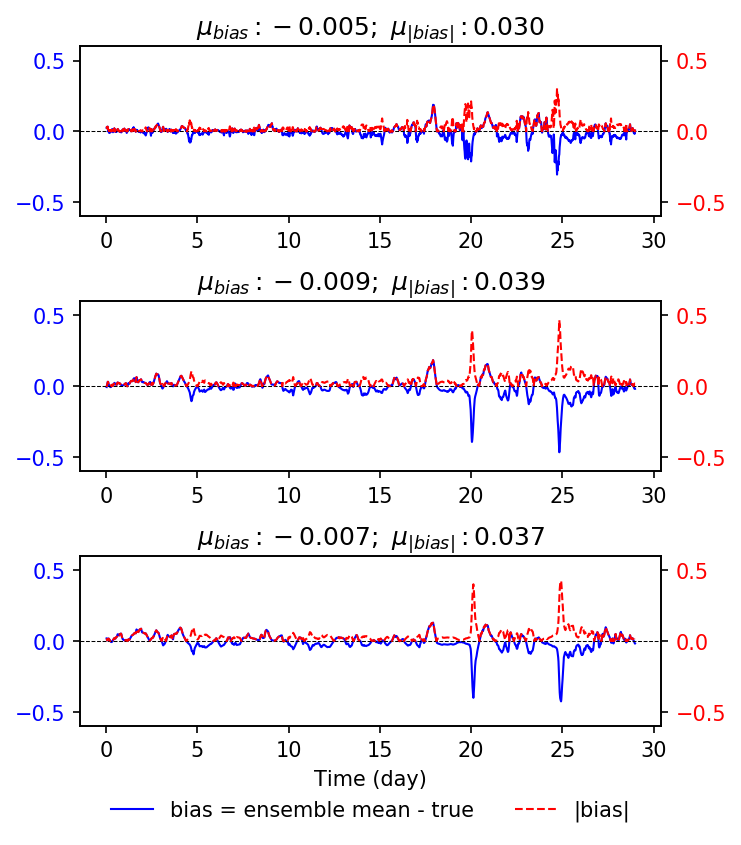

In [130]:
# Plot
fig = plt.figure(num=1, dpi=150, figsize=(5,6), constrained_layout=True)
gs = gridspec.GridSpec(nloc, 1, height_ratios=[1, 1, 1])

# Define axes array
axes = np.empty(nloc, dtype=object)

##############################
# Plot the temporal evolution of the ensemble, the mean, and the observation
# at each observed location
diff_mean_set = []
for i in range(nloc):
    posterior_current = posterior_set[i]
    posterior_current = posterior_current[(model_time_list>=obs_time_set_used[0]-0.000001)&
                                          (model_time_list<=obs_time_set_used[-1])]
    obs_used = obs_value_set_used['TEMPERATURE'][i, :]
    
    # Plot the error
    ax2 = plt.subplot(gs[i])
    diff = np.zeros([ntime, nens])
    for j in range(nens):
#         diff[:, j] = posterior_current[1:,j] - obs_used
        diff[:, j] = posterior_current[:,j] - obs_used
    diff_mean = np.mean(diff, axis=1)
    diff_mean_abs = np.abs(diff_mean)
    diff_std  = np.std(diff, axis=1)
    line1,=ax2.plot(obs_time_set_used, diff_mean, color='blue', linewidth=1, label='mean')
    ax2.axhline(y=0,color='k',linestyle='--',linewidth=0.5)
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.set_ylim([-.6,.6])
    diff_mean_set.append(diff_mean)
    
    # Plot the bias
    ax22 = ax2.twinx()  # instantiate a second axes that shares the same x-axis
#     ax22.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
    ax22.tick_params(axis='y', labelcolor='red')
    line2,=ax22.plot(obs_time_set_used, diff_mean_abs, '--', color='red', linewidth=1, label='mean')
    ax22.set_ylim([-.6,.6])
#     line3,=ax2.plot(obs_time_set_used, diff_std, '*-', color='black', linewidth=1, label='mean')

    axes[i] = ax2

for i in range(nloc):
    diff_mean = diff_mean_set[i]
    axes[i].set_title("$\mu_{bias}: %.3f;$ $\mu_{|bias|}: %.3f$" % 
                      (np.mean(diff_mean),np.mean(np.abs(diff_mean))))

# Plot the legends
# plt.legend(frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.9, -0.3))
plt.subplots_adjust(hspace=0.5)
plt.legend((line1, line2), ('bias = ensemble mean - true', '|bias|'), 
           frameon=False, ncol=3, loc="center", bbox_to_anchor=(0.5, -0.5))

# Plot the labels and titles
# axes[0].set_title("Posterior")
axes[-1].set_xlabel("Time (day)")
# for i in range(nloc):
#     axes[i].set_ylabel("Dimension z: \n %.2f (m)" % (obs_loc_set[2, i]))
# plt.savefig(os.path.join(fig_dir, app_dir_kewei_name+"_temperature_errorbias.png"), dpi=150)